# **Feature Engineering**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\ajv10\\Documents\\vscode-projects\\PP5\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\ajv10\\Documents\\vscode-projects\\PP5'

---

## Load Cleaned Data

### Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
print(TrainSet.shape)
TrainSet.head(3)

(2019, 18)


date        open        high         low       close  \
0  2015-10-12 00:00:00+01:00  628.906520  632.644103  625.473975  628.525085   
1  2015-10-05 00:00:00+01:00  630.050740  635.771588  628.525185  634.246033   
2  2017-10-30 00:00:00+00:00  673.760889  679.592424  671.966636  678.246704   

   volume    pre_open    pre_high     pre_low   pre_close   pre_vol  \
0  382846  628.525235  638.822628  628.525235  630.813599  507115.0   
1  398329  630.050708  630.050708  620.516002  623.948486  355145.0   
2  583454  681.835163  684.975197  676.210054  678.695251  497156.0   

   pre_open_2  pre_high_2   pre_low_2  pre_close_2  pre_vol_2     average  \
0  630.050676  632.720413  623.567081   628.906555   376258.0  628.715803   
1  623.185739  630.050708  622.041557   623.948486   546269.0  632.148386   
2  667.929442  681.386704  667.929442   680.938171   856953.0  676.003796   

   target  
0       0  
1       0  
2       1

### Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
print(TestSet.shape)
TestSet.head(3)

(505, 18)


date        open        high         low       close  \
0  2024-03-05 00:00:00+00:00  496.718773  499.216354  491.723613  495.420013   
1  2021-05-11 00:00:00+01:00  721.900572  727.894764  712.709525  713.708557   
2  2017-04-20 00:00:00+01:00  664.789382  666.135163  659.226139  665.237976   

    volume    pre_open    pre_high     pre_low   pre_close    pre_vol  \
0  2890167  500.914661  501.713905  494.321044  500.115448  1844690.0   
1  1351087  735.287632  741.220910  726.895738  731.291504  2265134.0   
2  2181626  668.377965  676.900818  663.443618  663.892151  1122421.0   

   pre_open_2  pre_high_2   pre_low_2  pre_close_2  pre_vol_2     average  \
0  501.713918  504.910802  498.217305   501.514099  2220748.0  496.069393   
1  735.687254  739.083927  731.091670   734.488403  1237260.0  717.804564   
2  672.415195  674.433775  665.686473   669.723694  1860339.0  665.013679   

   target  
0       1  
1       1  
2       0

---

## Data Exploration

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Section 1

Section 1 content

## Feature Engineering

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

In [8]:
feature_names = [TrainSet.columns[0]]
feature_names

['date']

In [9]:
variables_engineering = feature_names
variables_engineering

['date']

In [10]:
df_engineering = TrainSet[variables_engineering].copy()
print(df_engineering.shape)
df_engineering.head(3)

(2019, 1)


date
0  2015-10-12 00:00:00+01:00
1  2015-10-05 00:00:00+01:00
2  2017-10-30 00:00:00+00:00

* Variable Analyzed: date
* Applied transformation: ['date_ordinal_encoder'] 



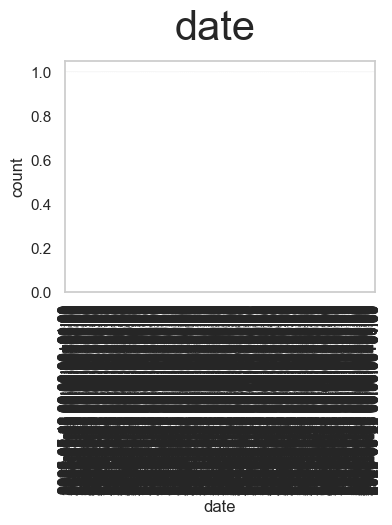

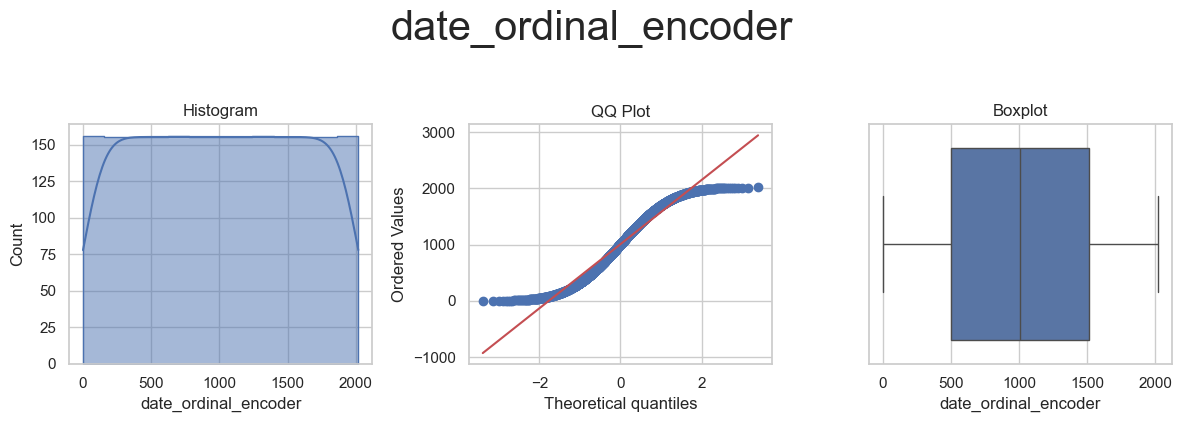

In [11]:
%matplotlib inline
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

In [12]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


---

In [13]:
feature_names = TrainSet.columns.tolist()[1:6]
feature_names

['open', 'high', 'low', 'close', 'volume']

In [14]:
variables_engineering = feature_names
variables_engineering

['open', 'high', 'low', 'close', 'volume']

In [15]:
df_engineering = TrainSet[variables_engineering].copy()
print(df_engineering.shape)
df_engineering.head(3)

(2019, 5)


open        high         low       close  volume
0  628.906520  632.644103  625.473975  628.525085  382846
1  630.050740  635.771588  628.525185  634.246033  398329
2  673.760889  679.592424  671.966636  678.246704  583454

* Variable Analyzed: open
* Applied transformation: ['open_log_e', 'open_log_10', 'open_reciprocal', 'open_power', 'open_box_cox', 'open_yeo_johnson'] 



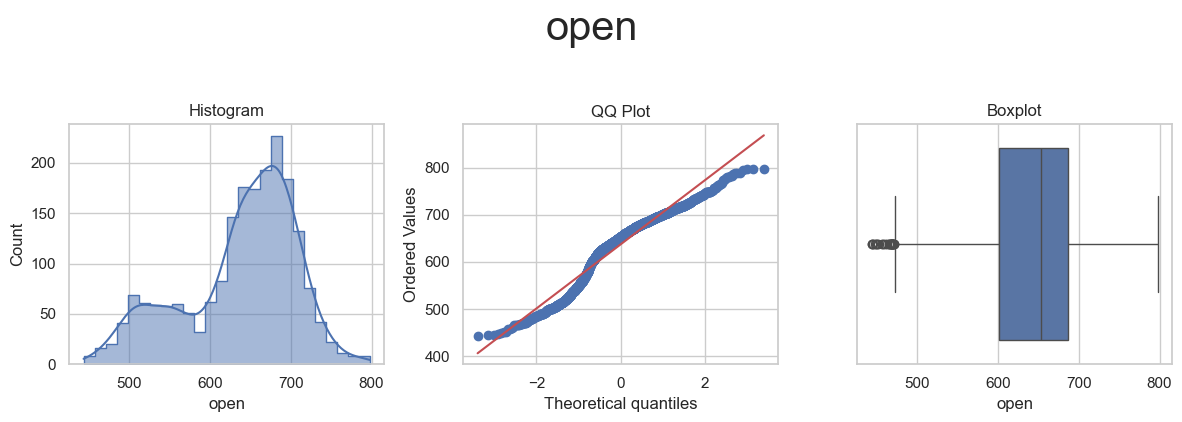

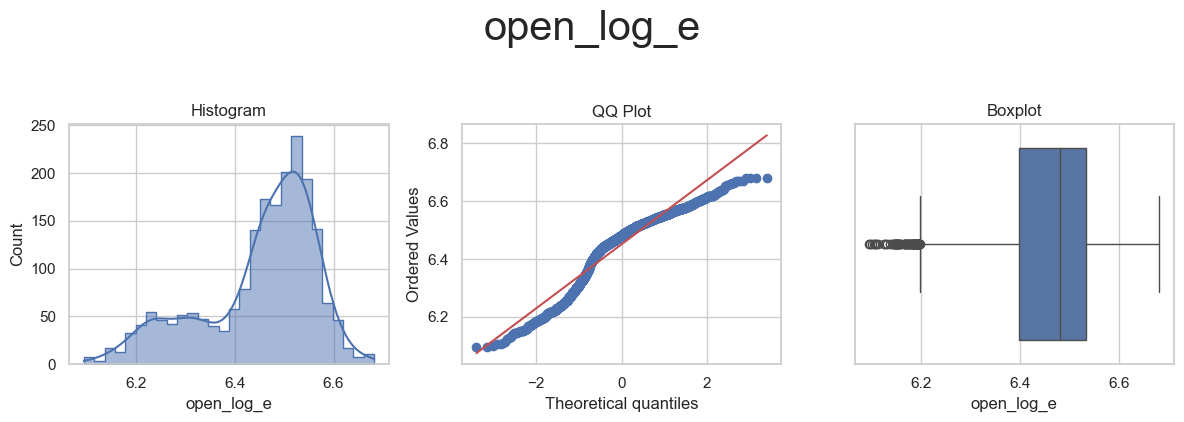

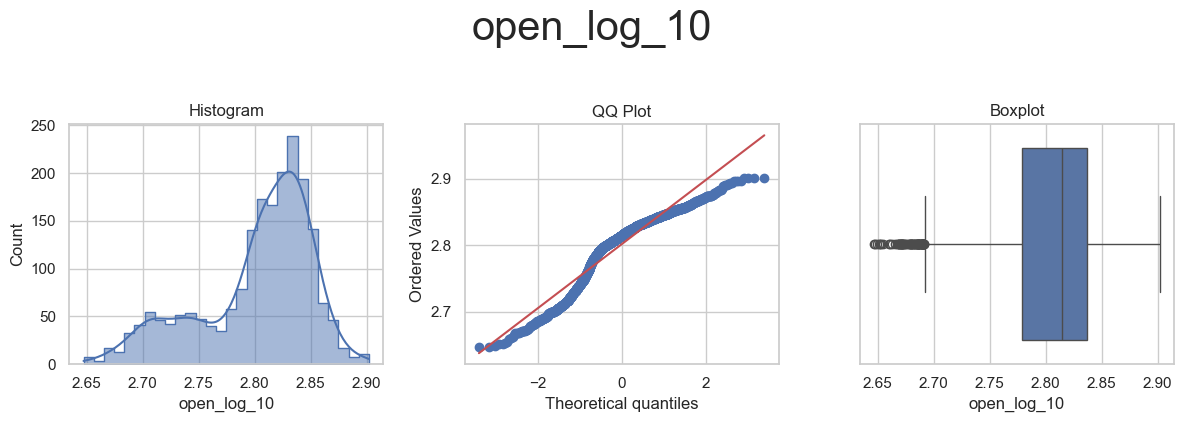

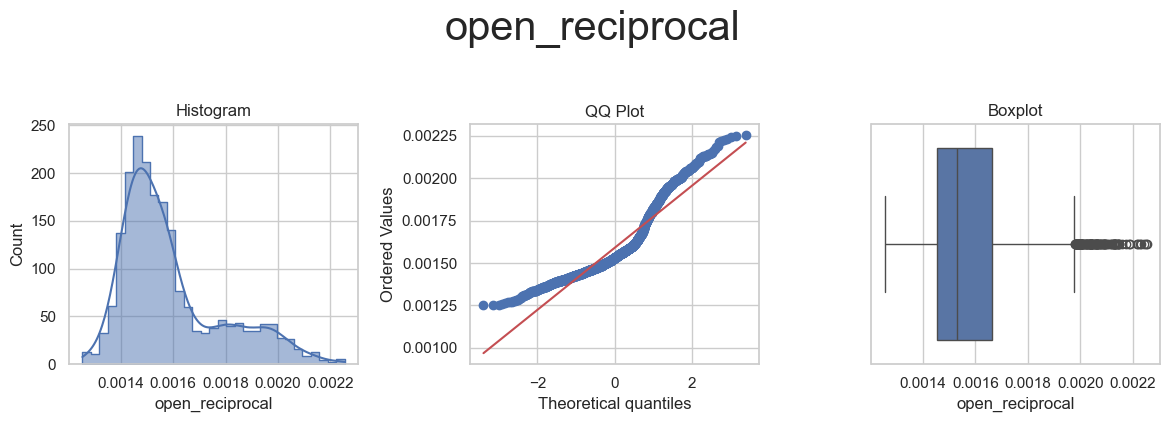

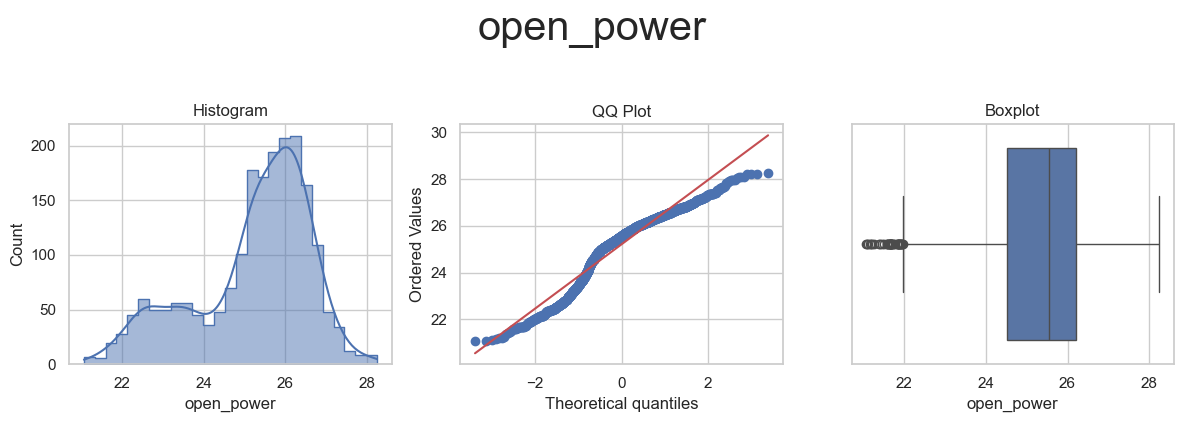

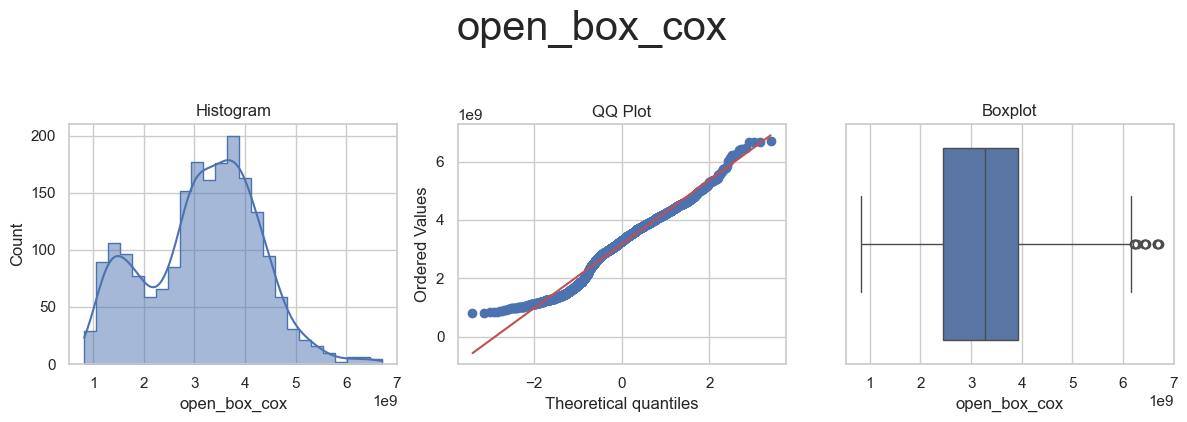

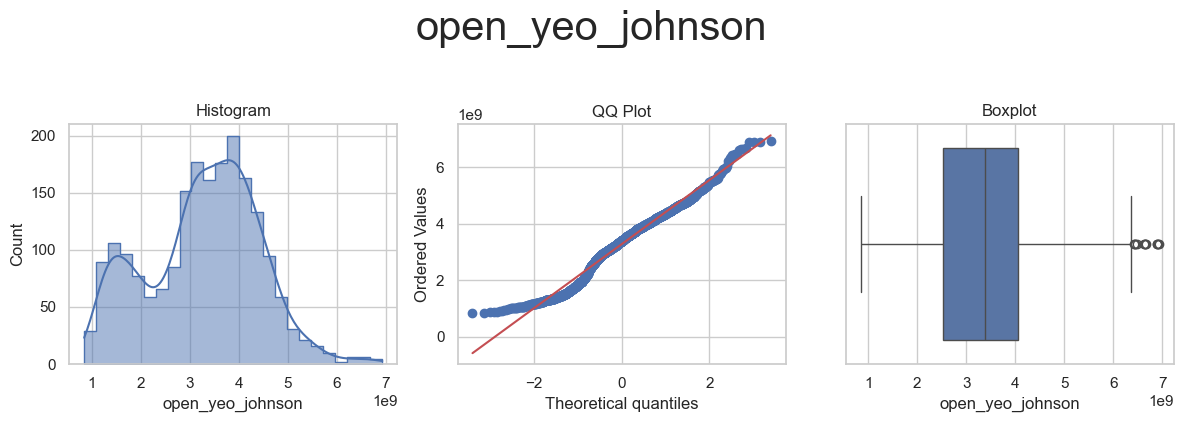



* Variable Analyzed: high
* Applied transformation: ['high_log_e', 'high_log_10', 'high_reciprocal', 'high_power', 'high_box_cox', 'high_yeo_johnson'] 



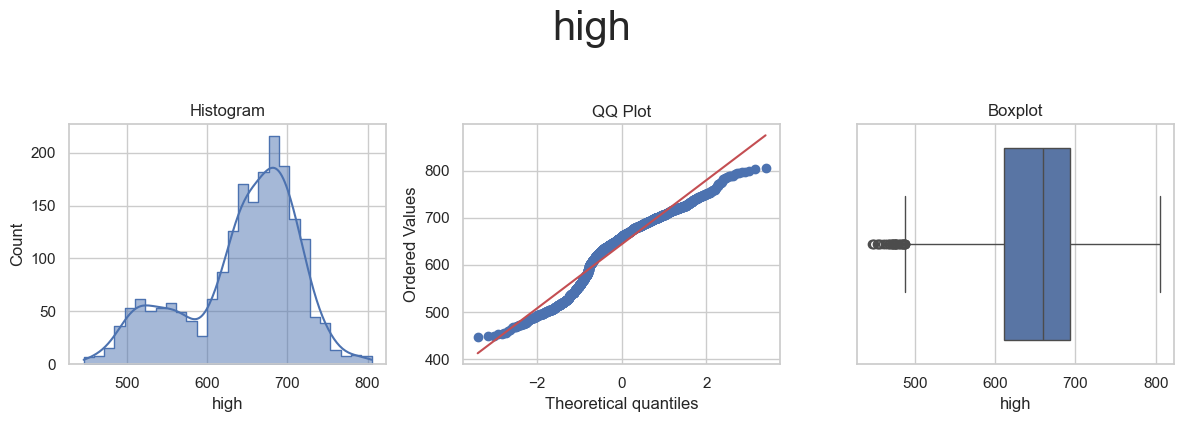

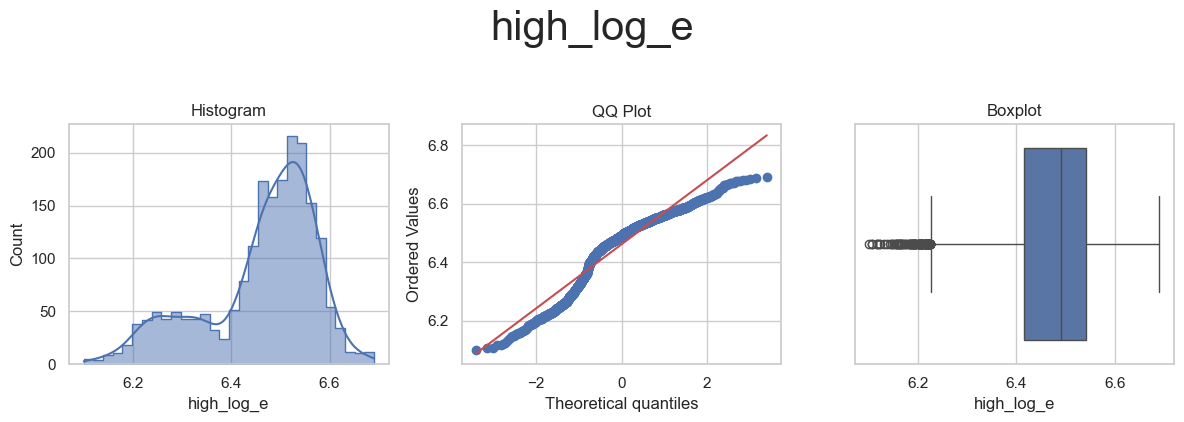

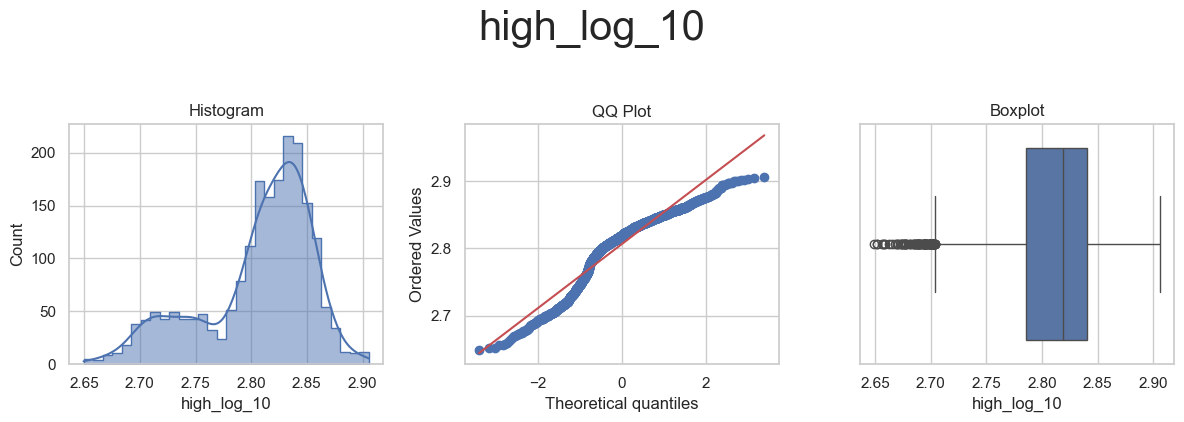

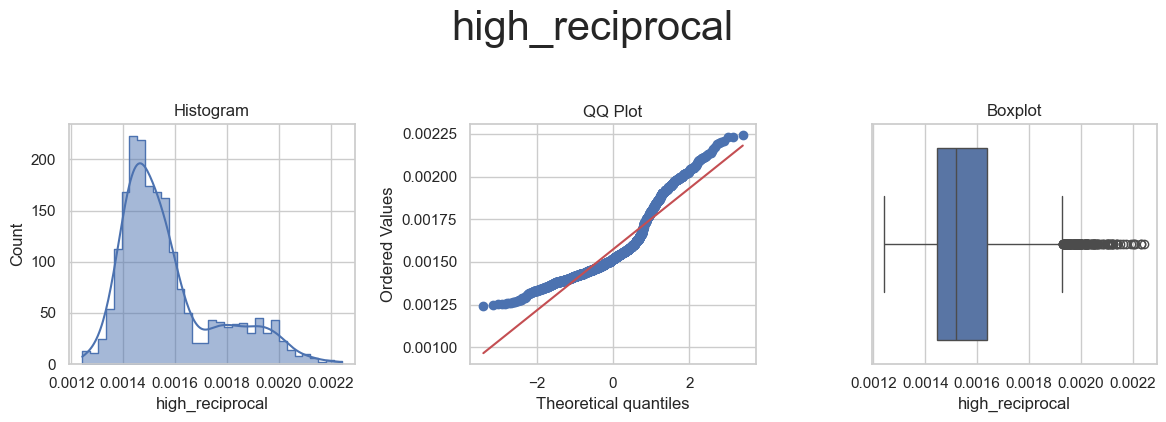

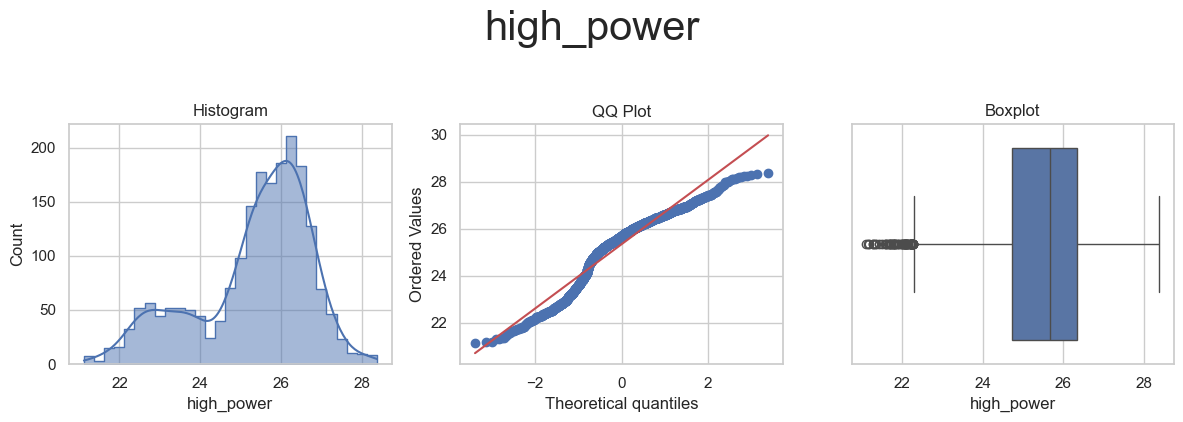

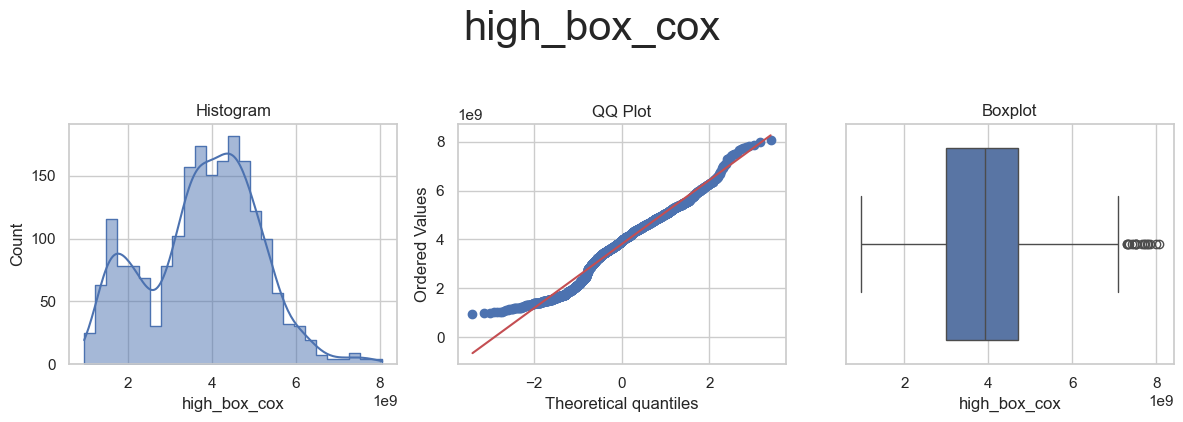

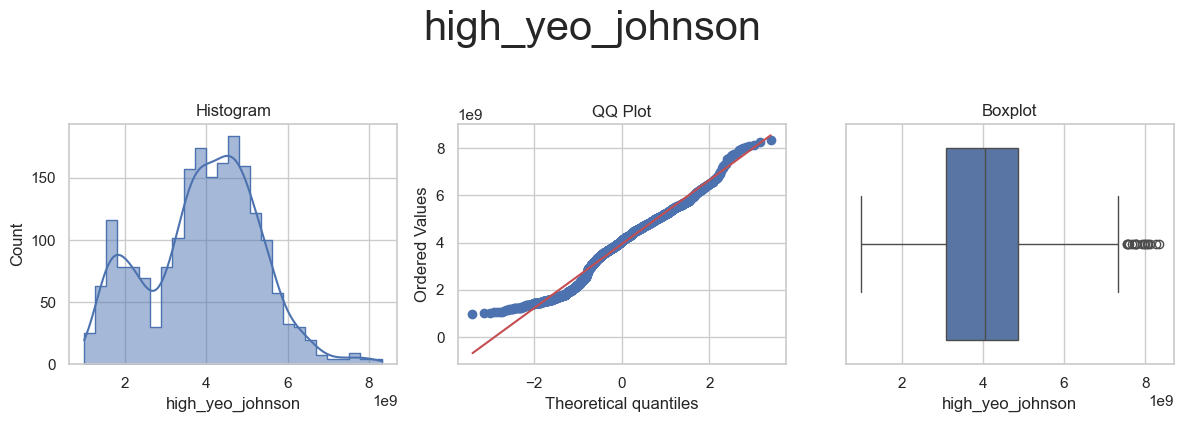



* Variable Analyzed: low
* Applied transformation: ['low_log_e', 'low_log_10', 'low_reciprocal', 'low_power', 'low_box_cox', 'low_yeo_johnson'] 



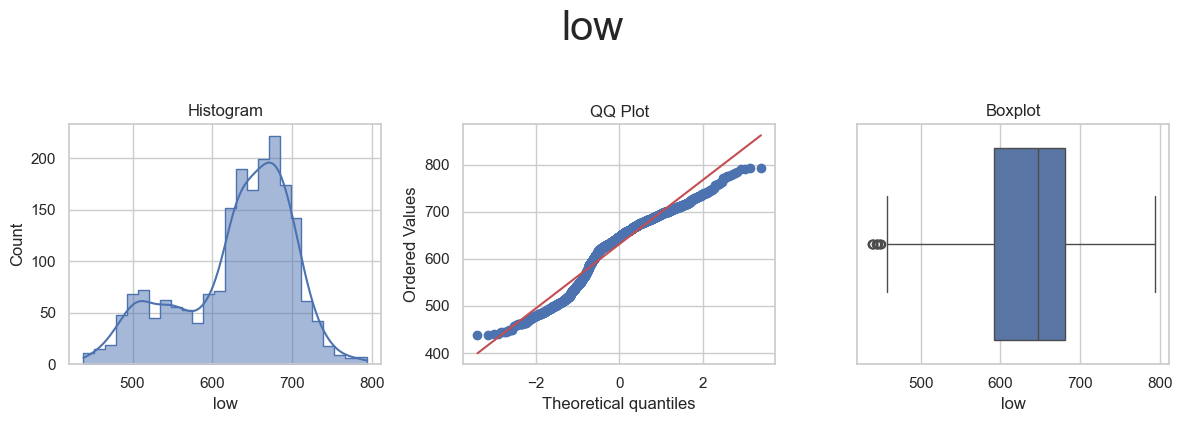

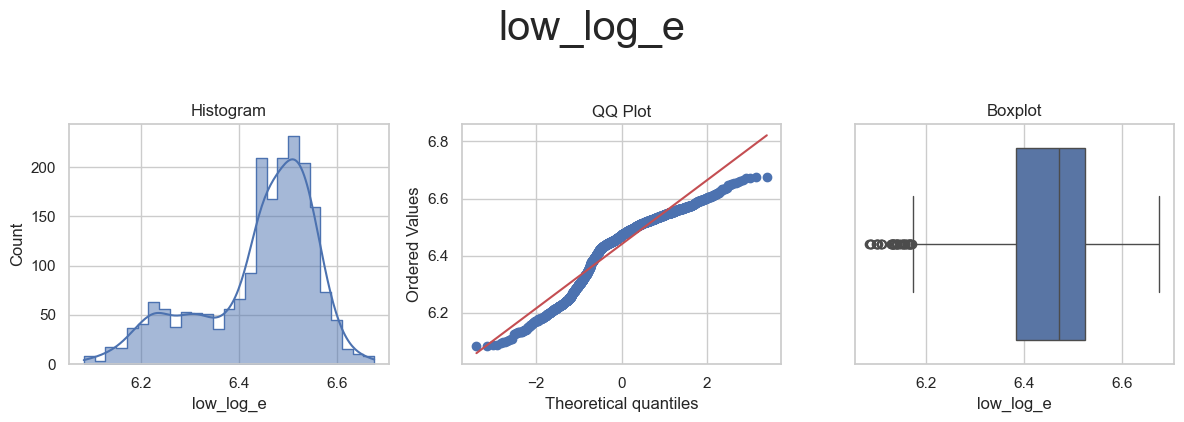

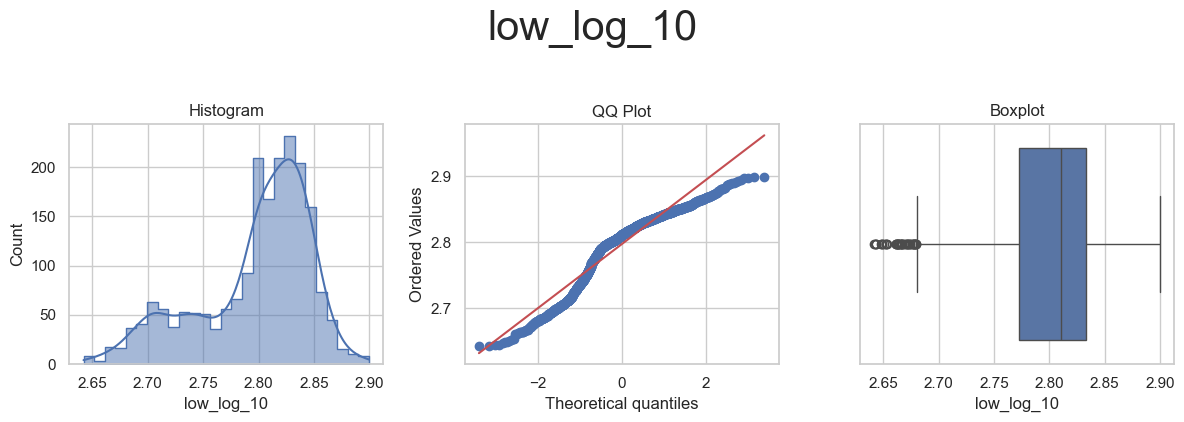

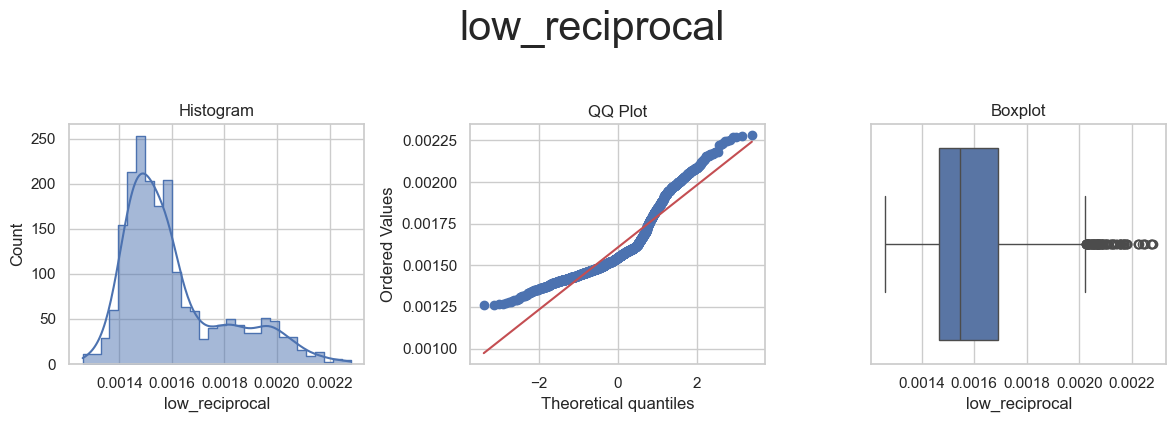

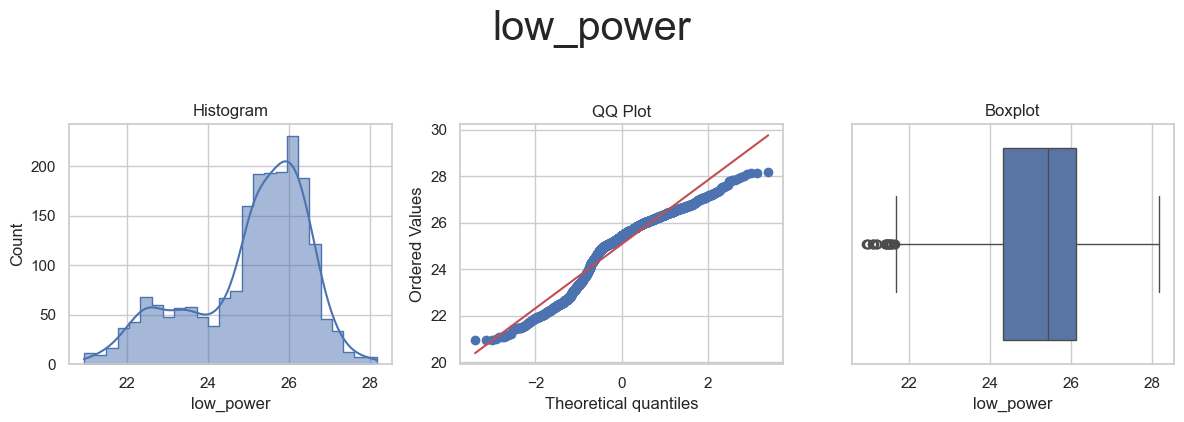

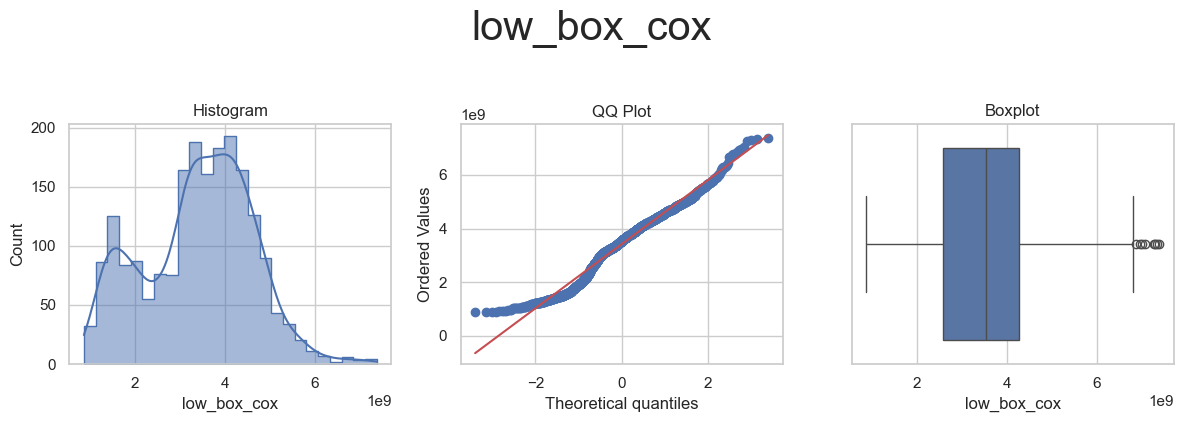

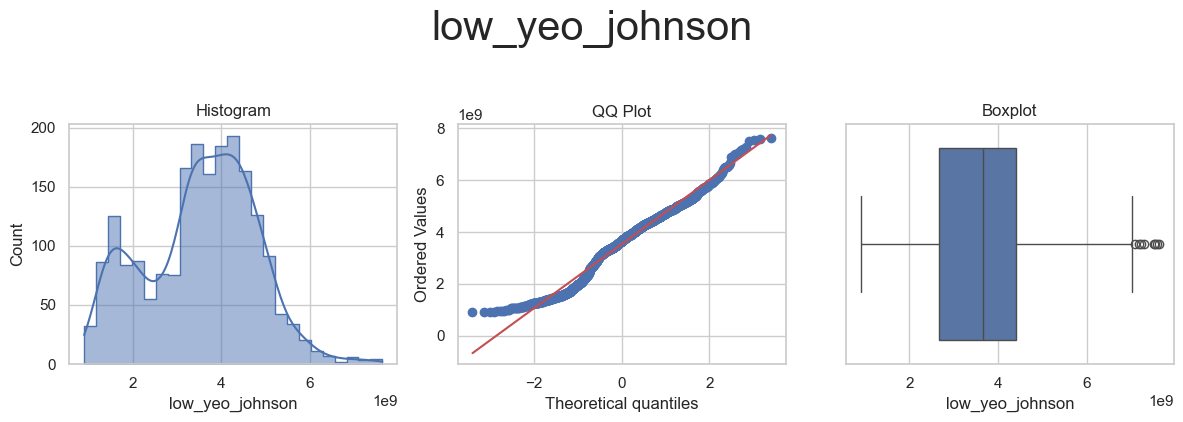



* Variable Analyzed: close
* Applied transformation: ['close_log_e', 'close_log_10', 'close_reciprocal', 'close_power', 'close_box_cox', 'close_yeo_johnson'] 



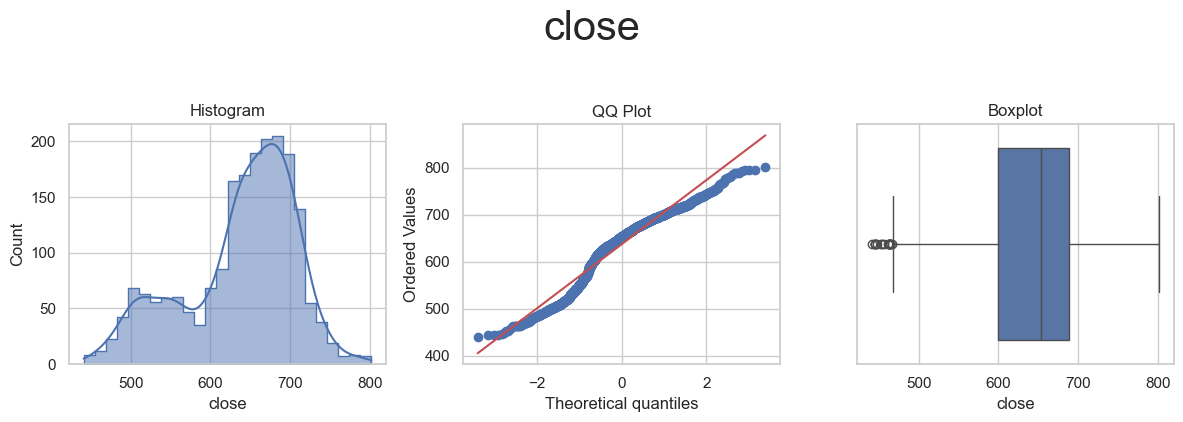

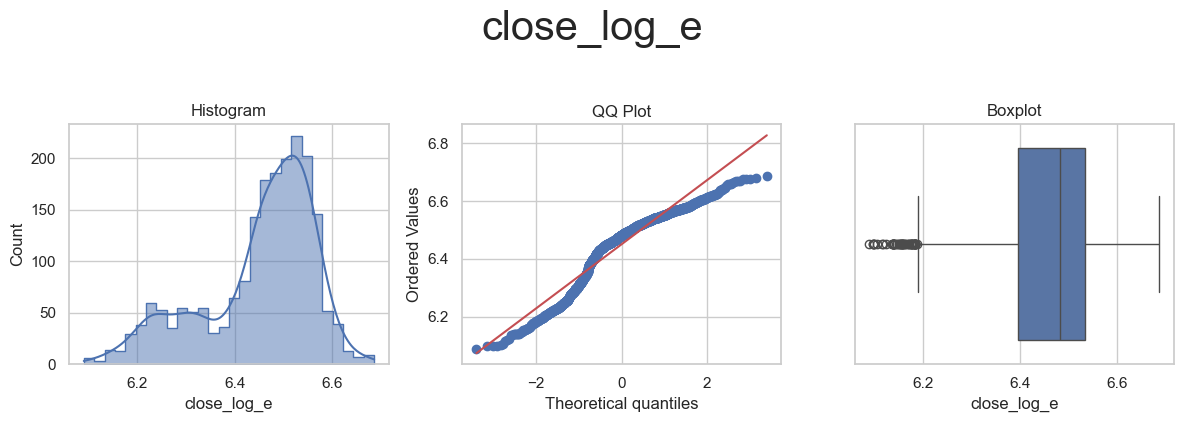

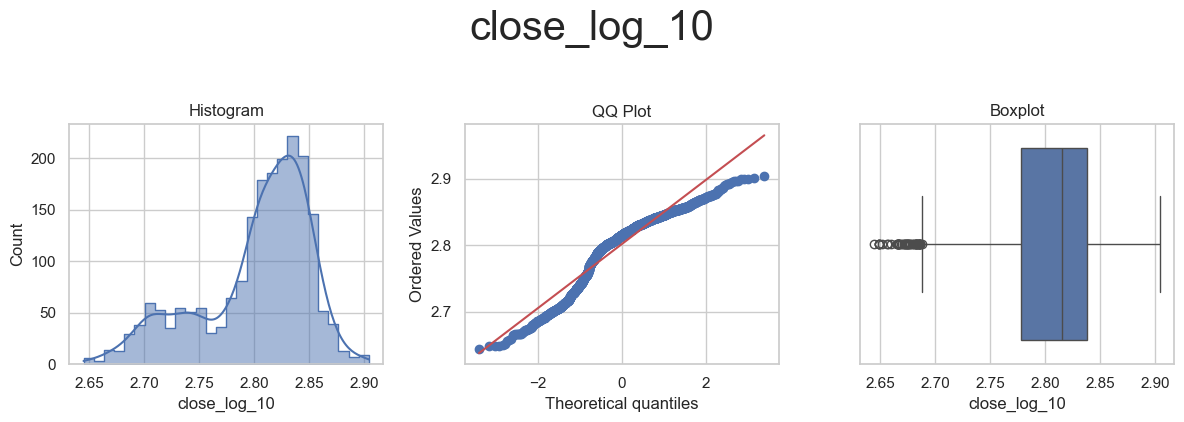

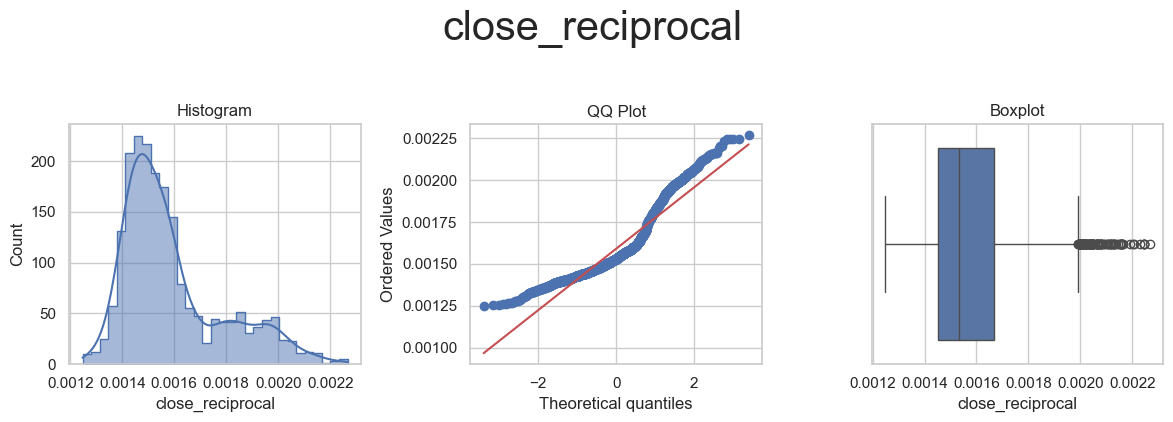

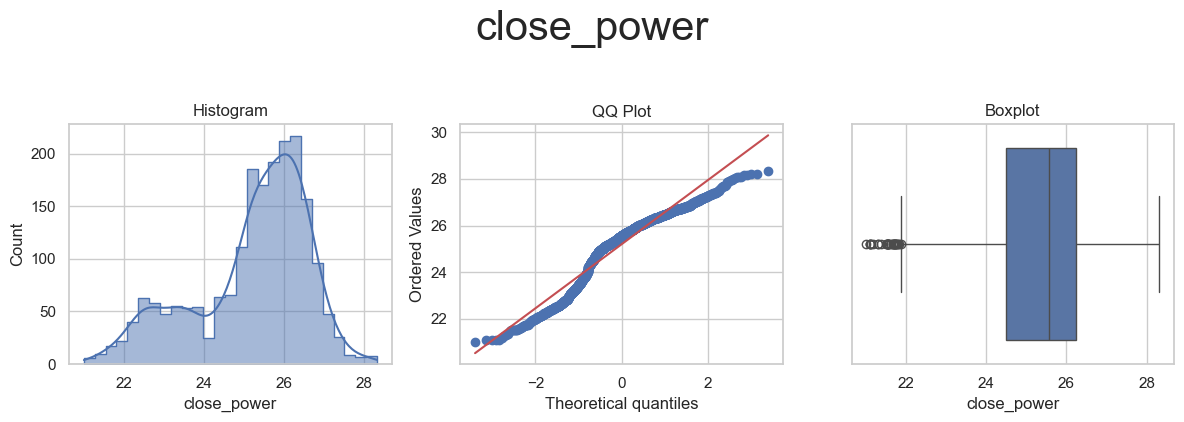

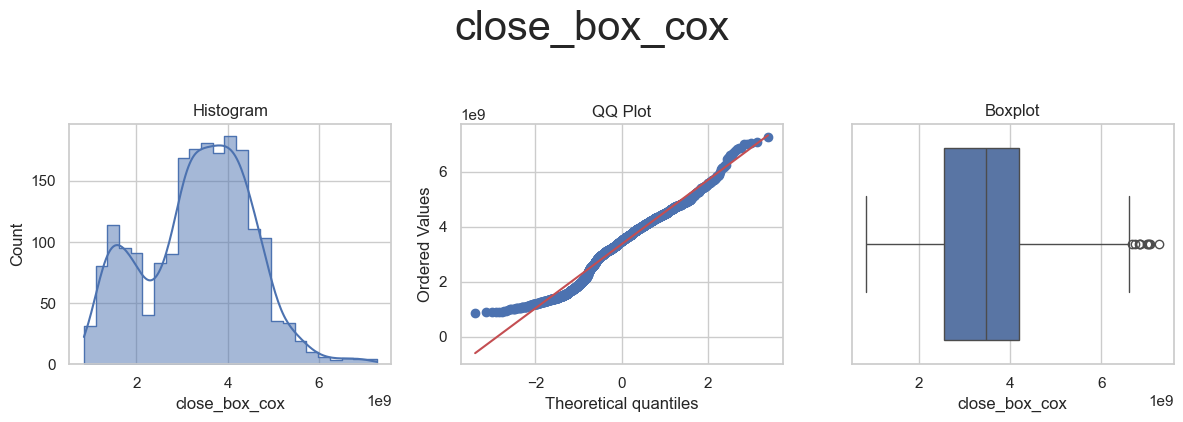

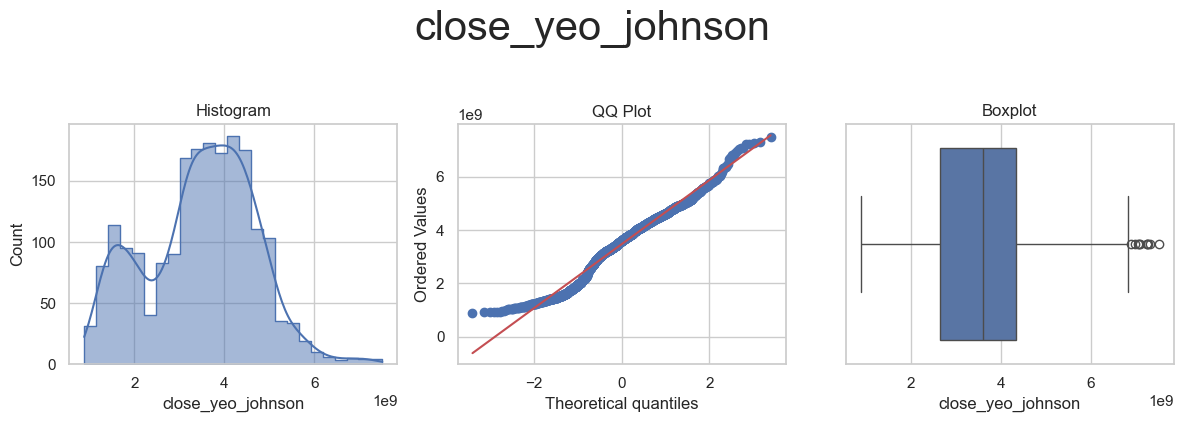



* Variable Analyzed: volume
* Applied transformation: ['volume_power', 'volume_yeo_johnson'] 



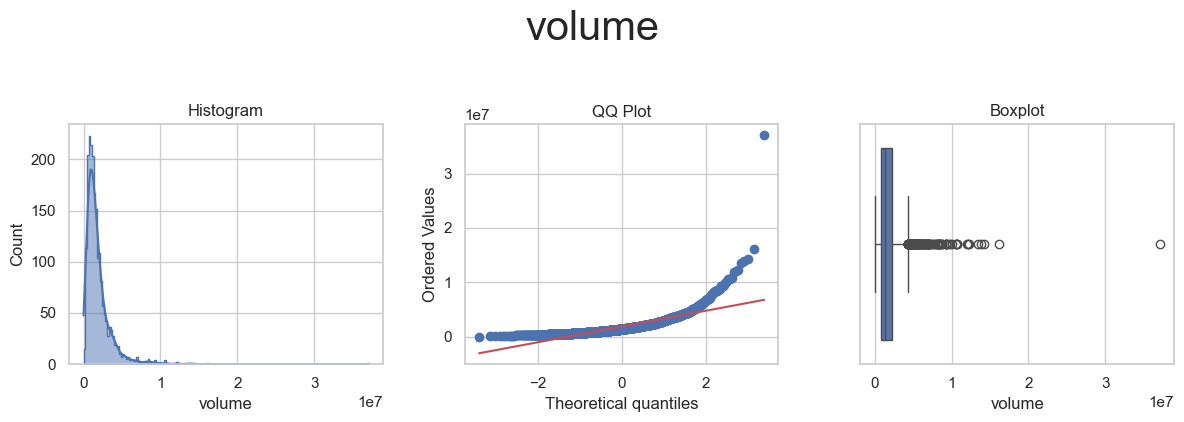

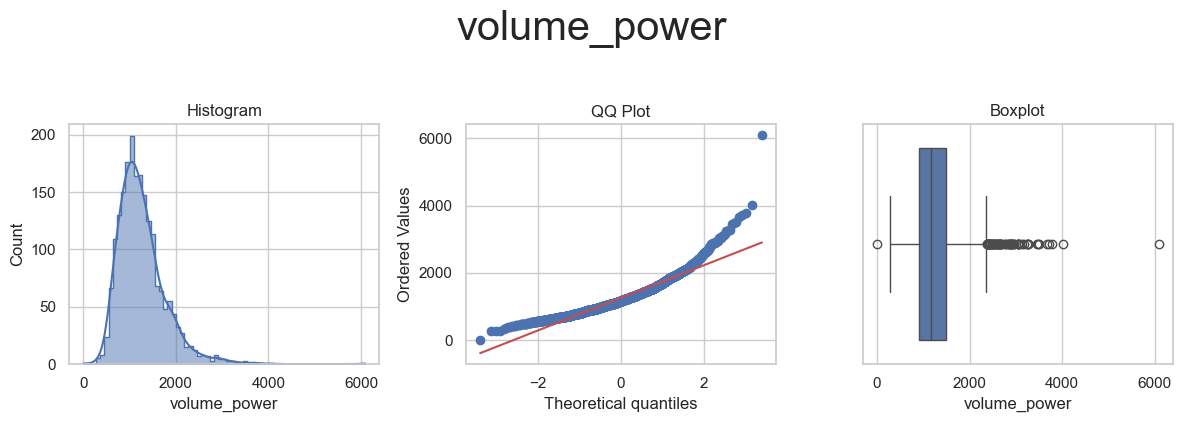

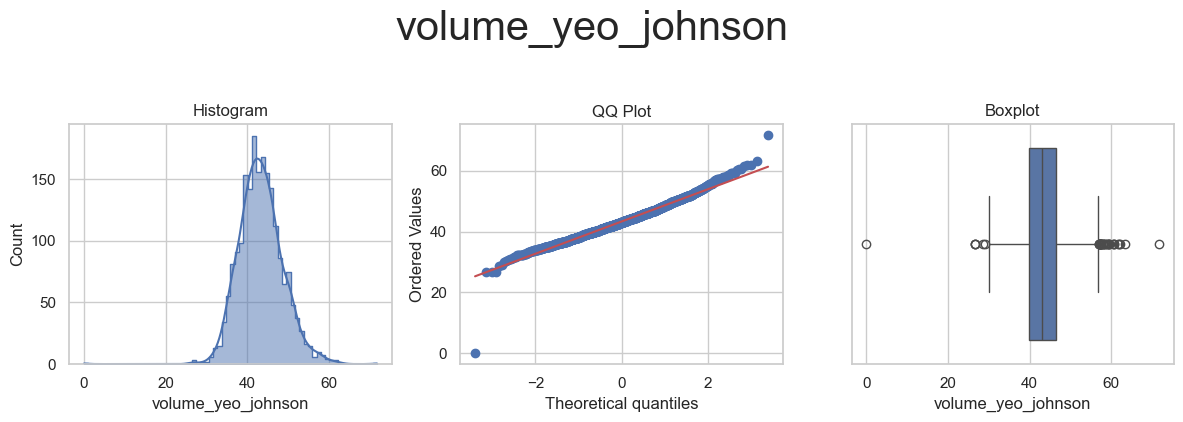

In [16]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* Variable Analyzed: open
* Applied transformation: ['open_iqr'] 



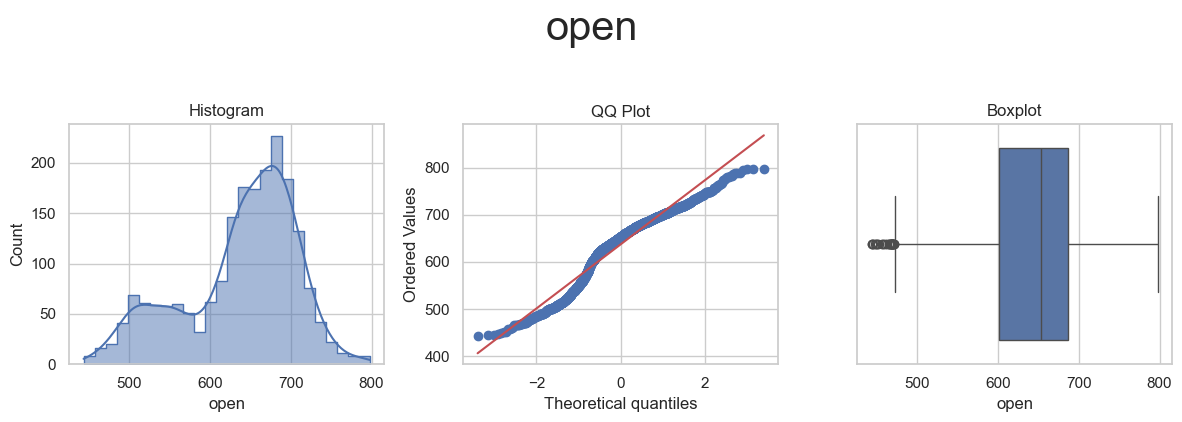

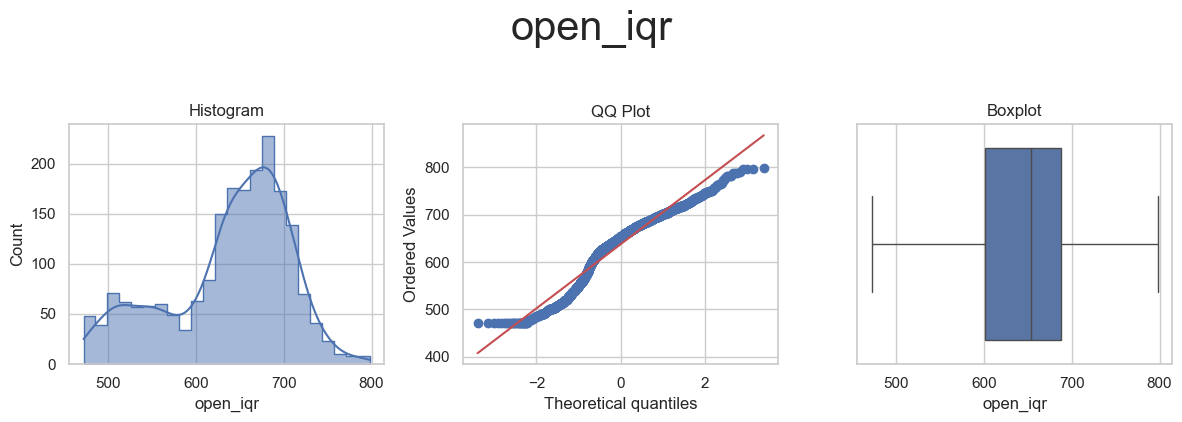



* Variable Analyzed: open_log_e
* Applied transformation: ['open_log_e_iqr'] 



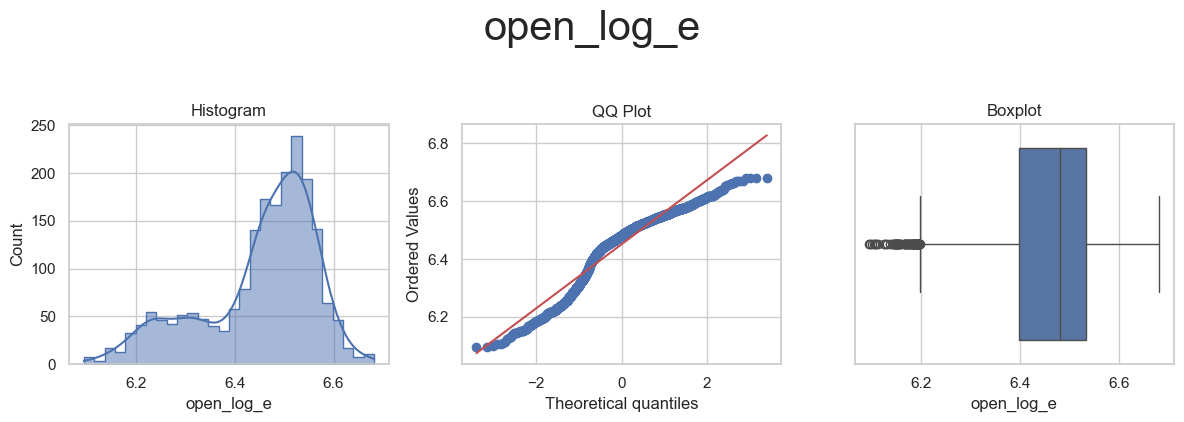

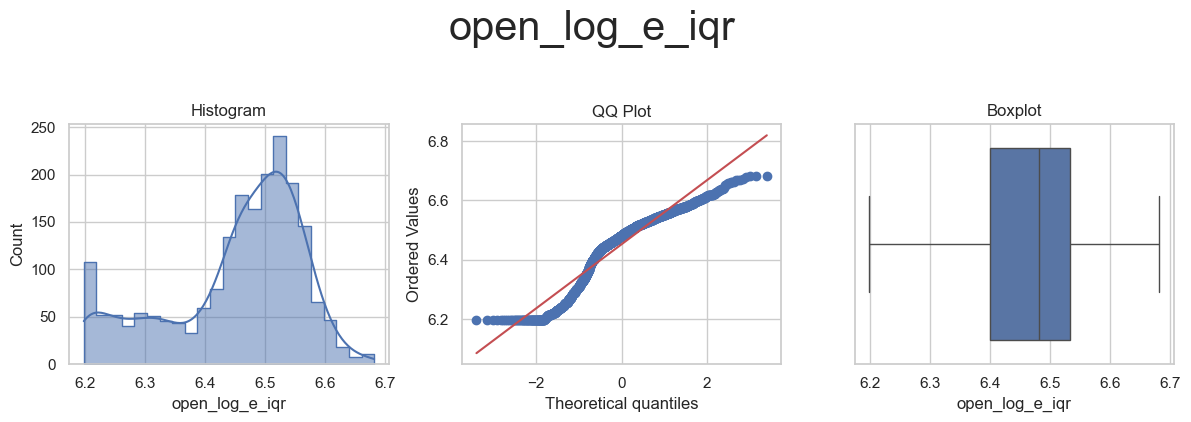



* Variable Analyzed: open_log_10
* Applied transformation: ['open_log_10_iqr'] 



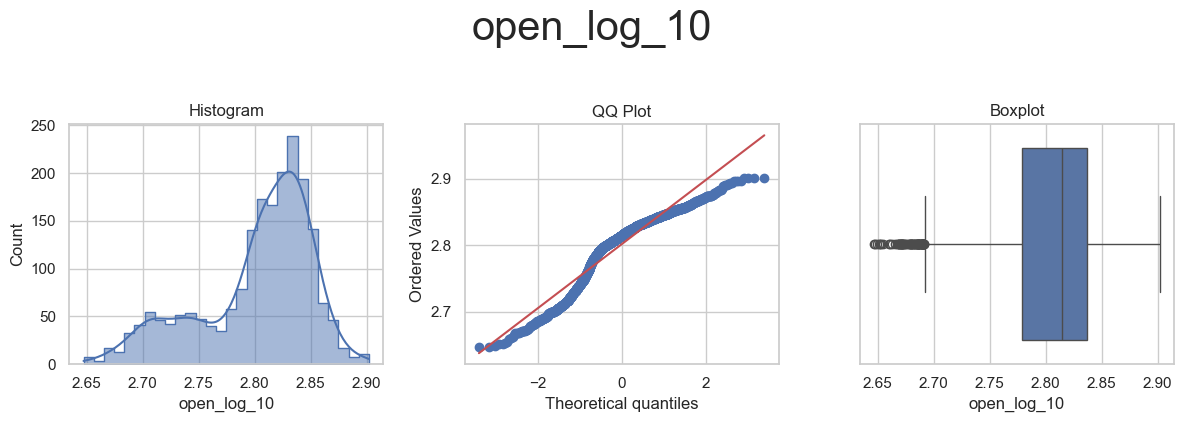

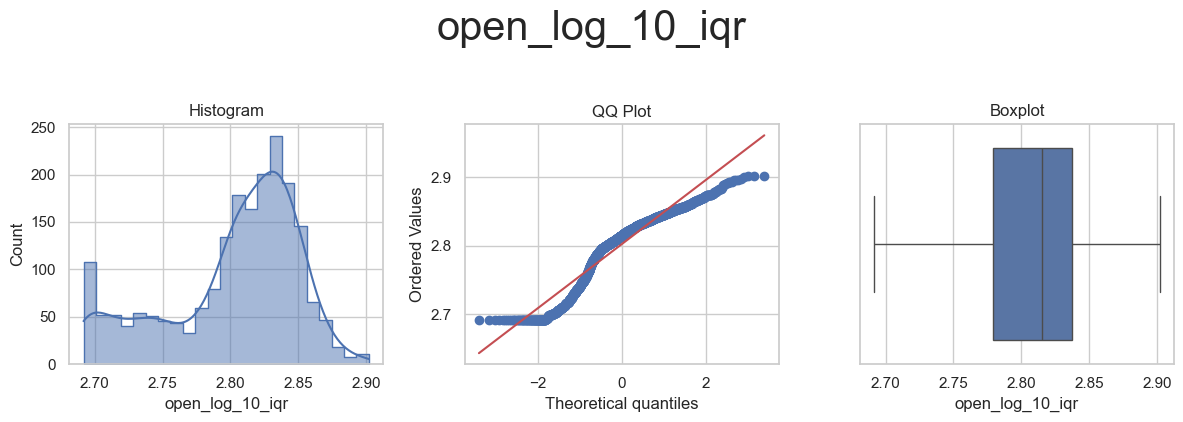



* Variable Analyzed: open_reciprocal
* Applied transformation: ['open_reciprocal_iqr'] 



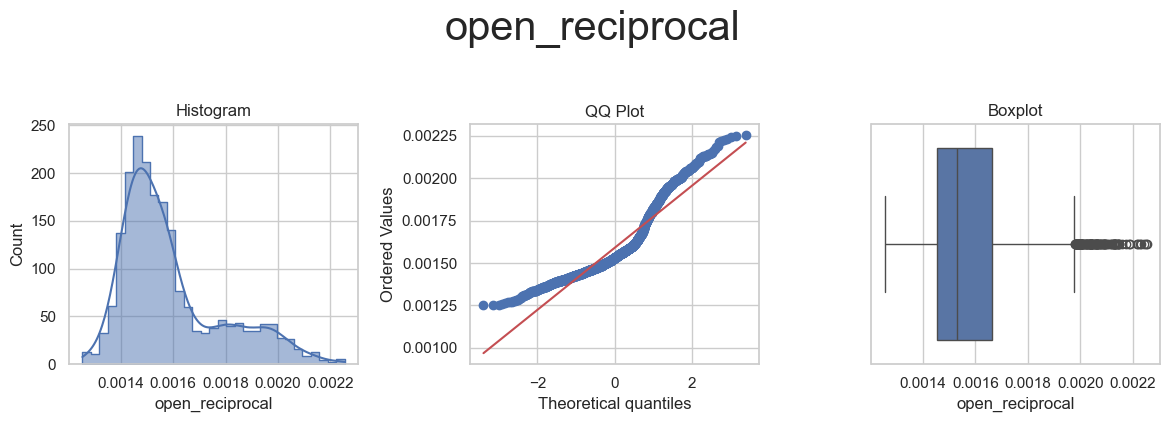

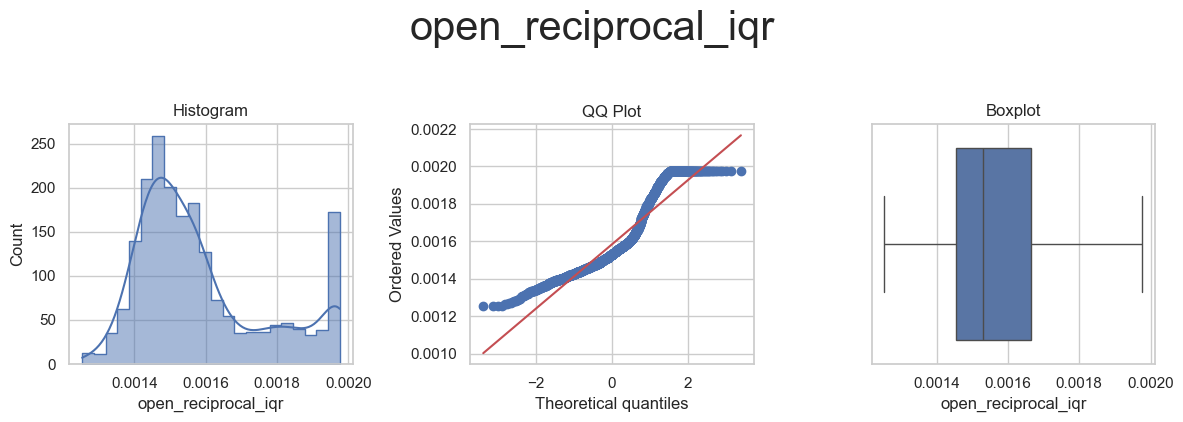



* Variable Analyzed: open_power
* Applied transformation: ['open_power_iqr'] 



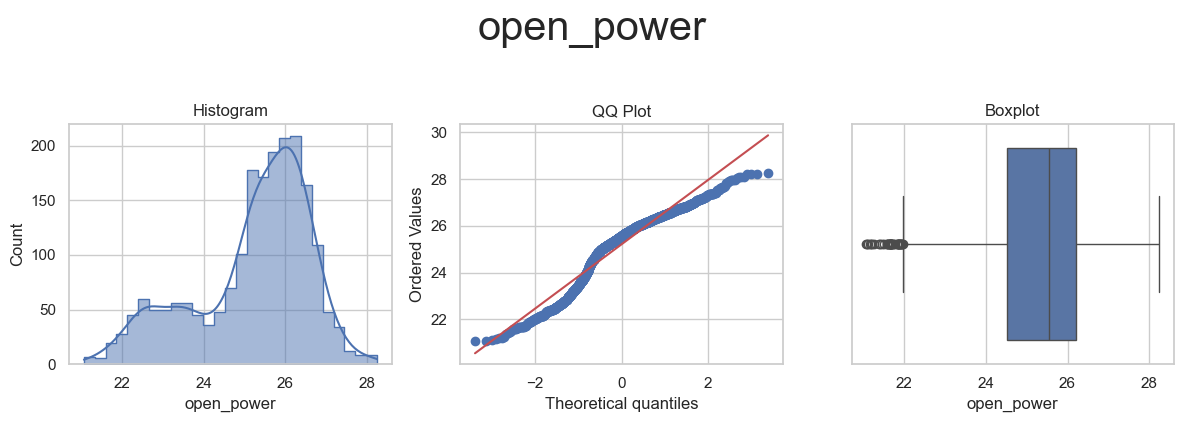

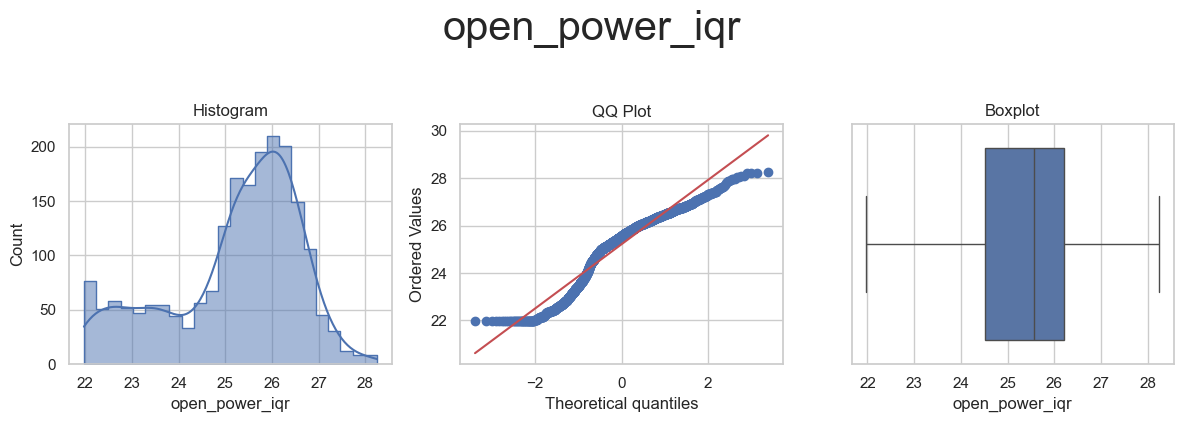



* Variable Analyzed: open_box_cox
* Applied transformation: ['open_box_cox_iqr'] 



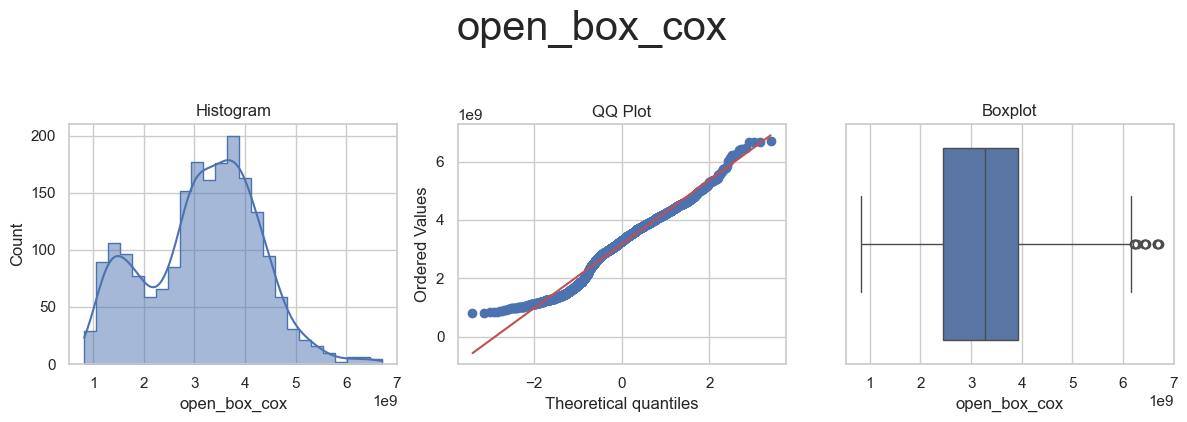

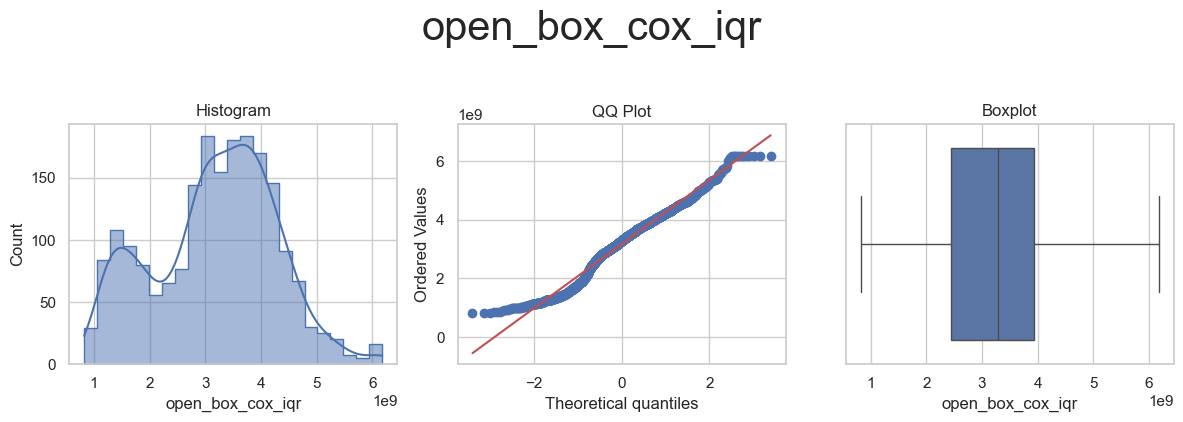



* Variable Analyzed: open_yeo_johnson
* Applied transformation: ['open_yeo_johnson_iqr'] 



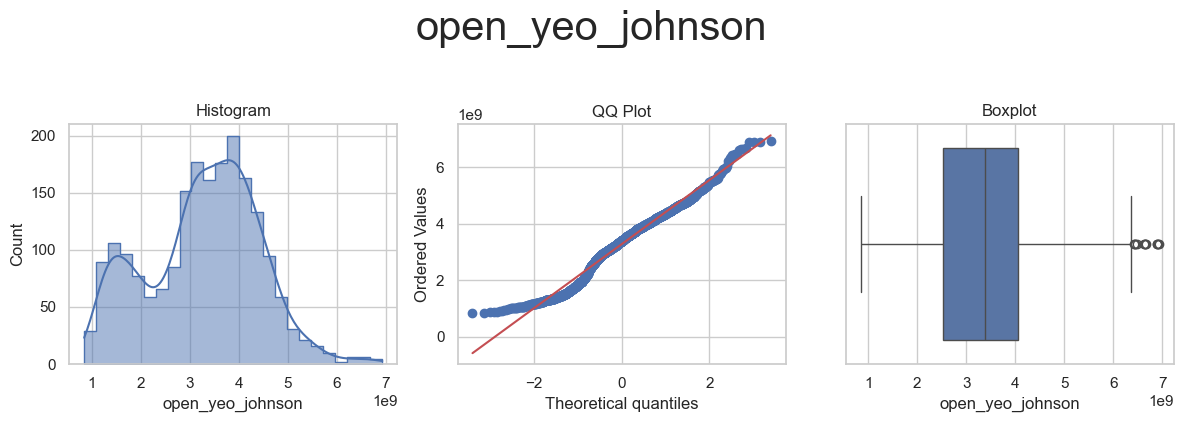

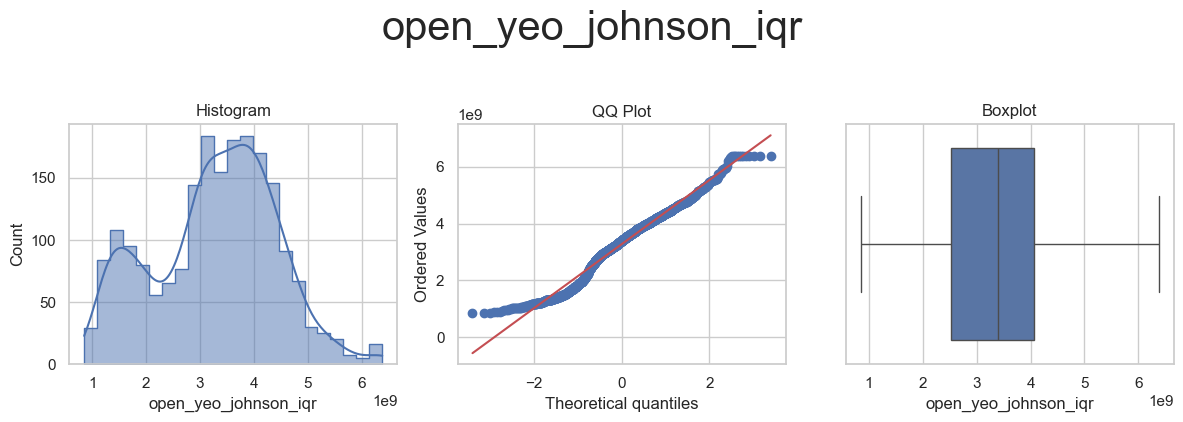



* Variable Analyzed: high
* Applied transformation: ['high_iqr'] 



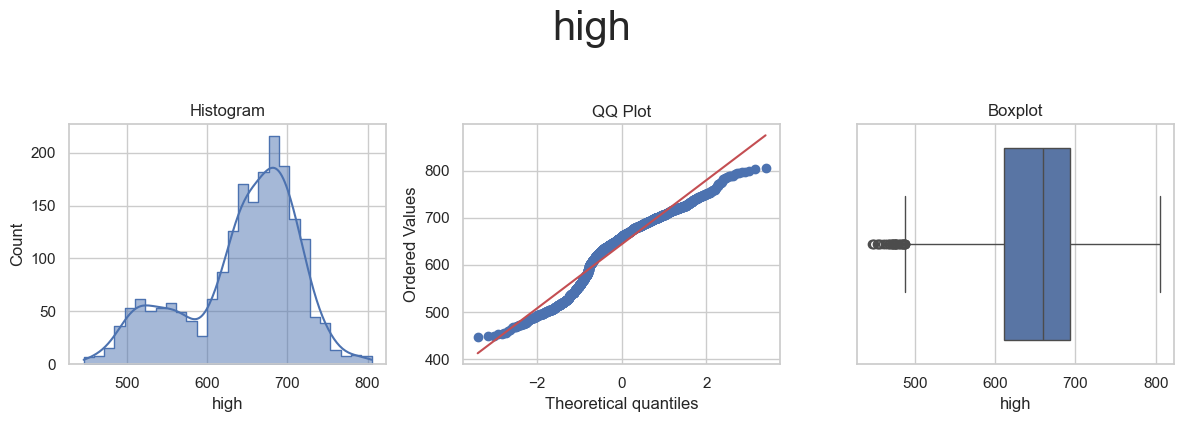

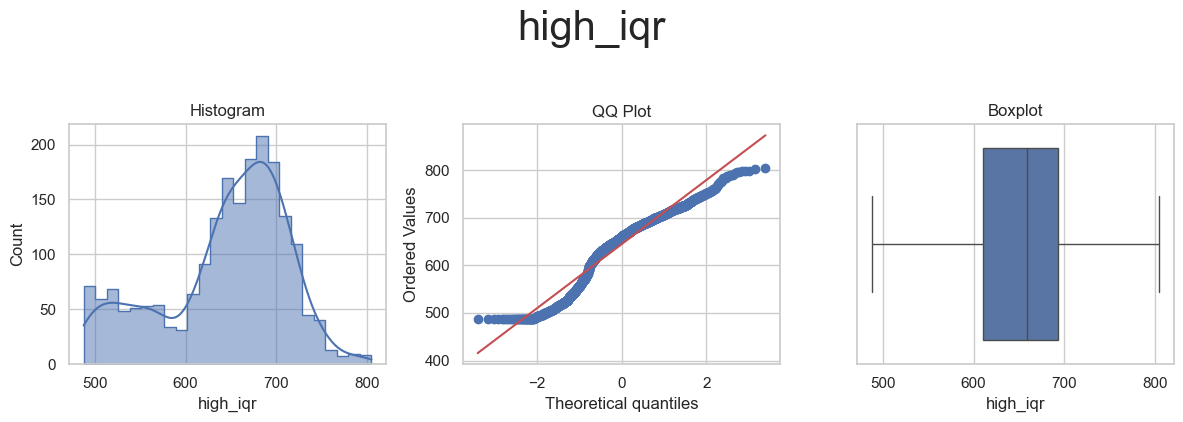



* Variable Analyzed: high_log_e
* Applied transformation: ['high_log_e_iqr'] 



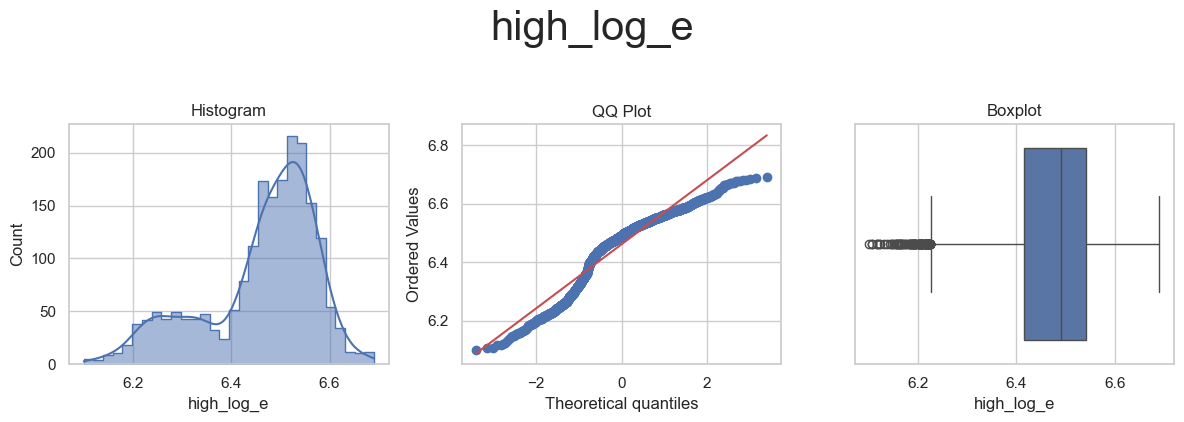

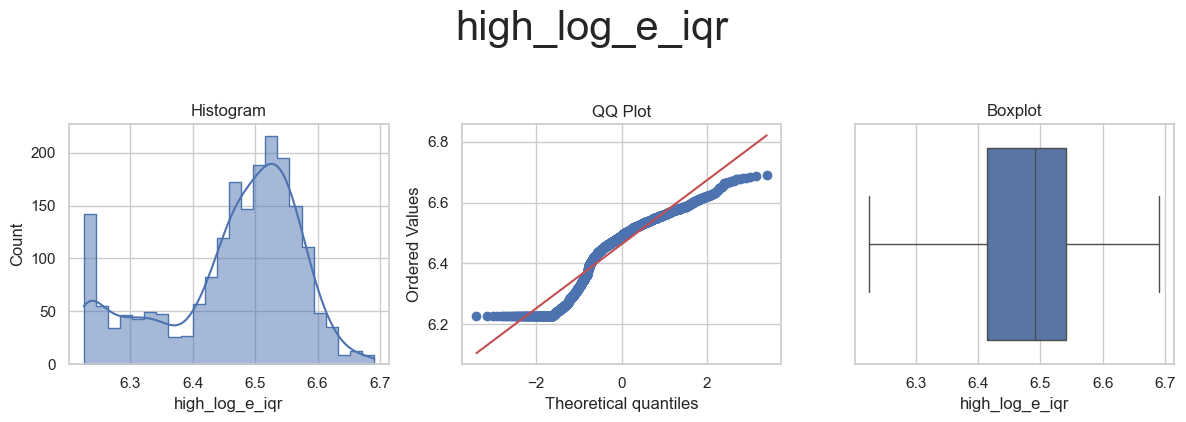



* Variable Analyzed: high_log_10
* Applied transformation: ['high_log_10_iqr'] 



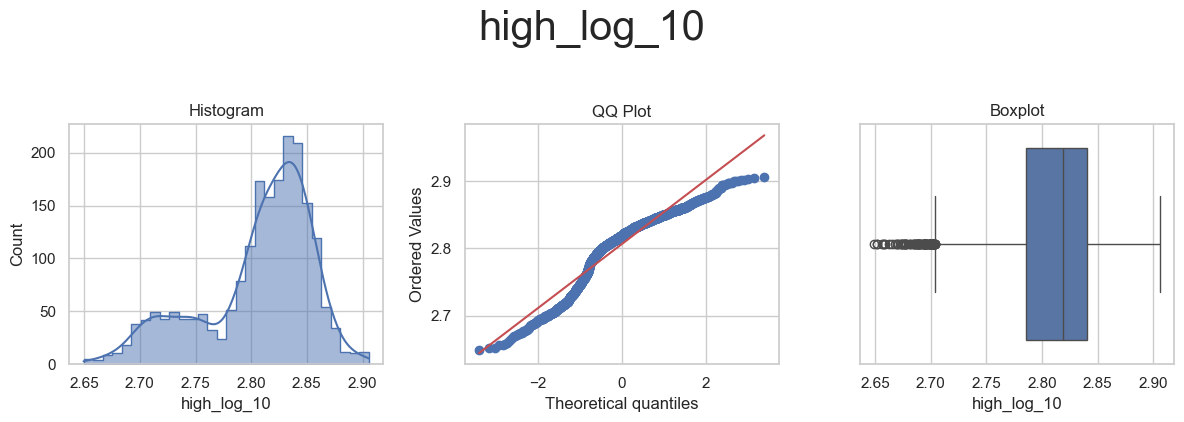

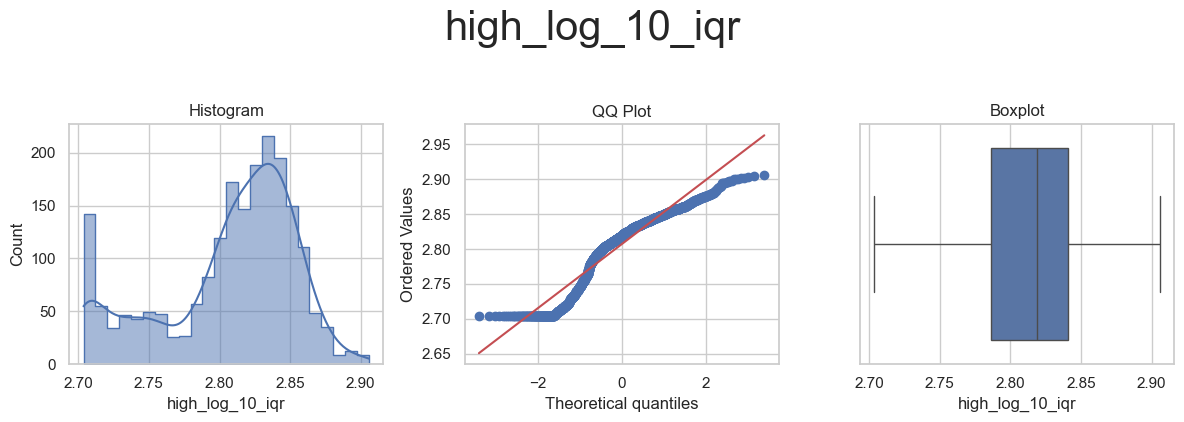



* Variable Analyzed: high_reciprocal
* Applied transformation: ['high_reciprocal_iqr'] 



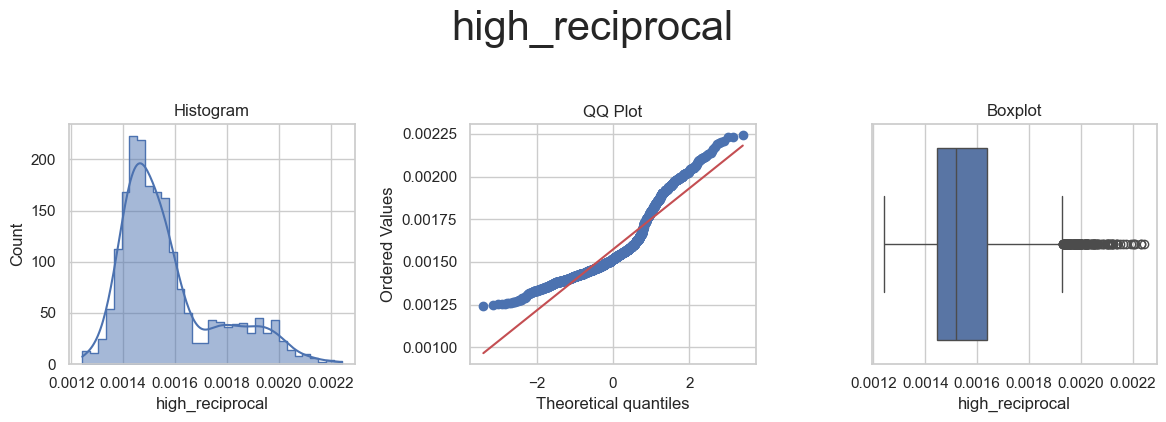

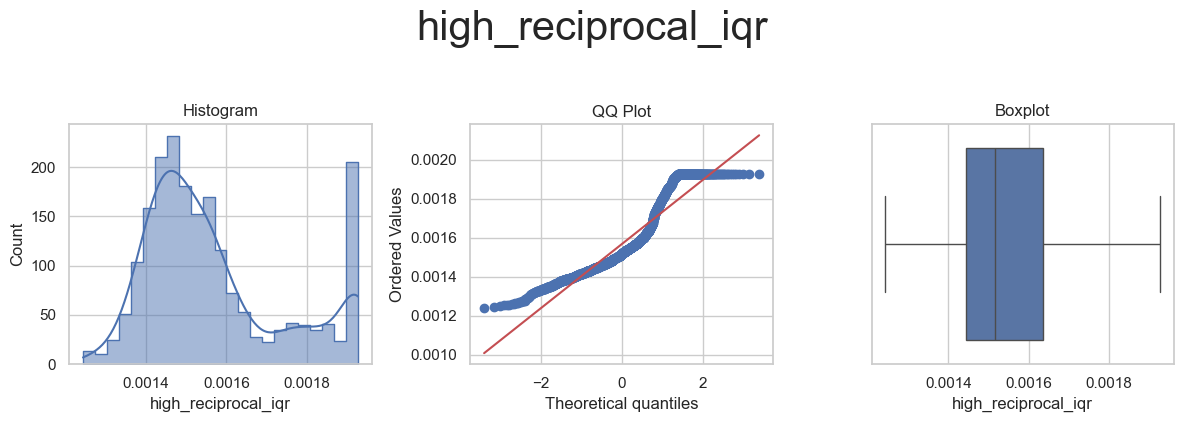



* Variable Analyzed: high_power
* Applied transformation: ['high_power_iqr'] 



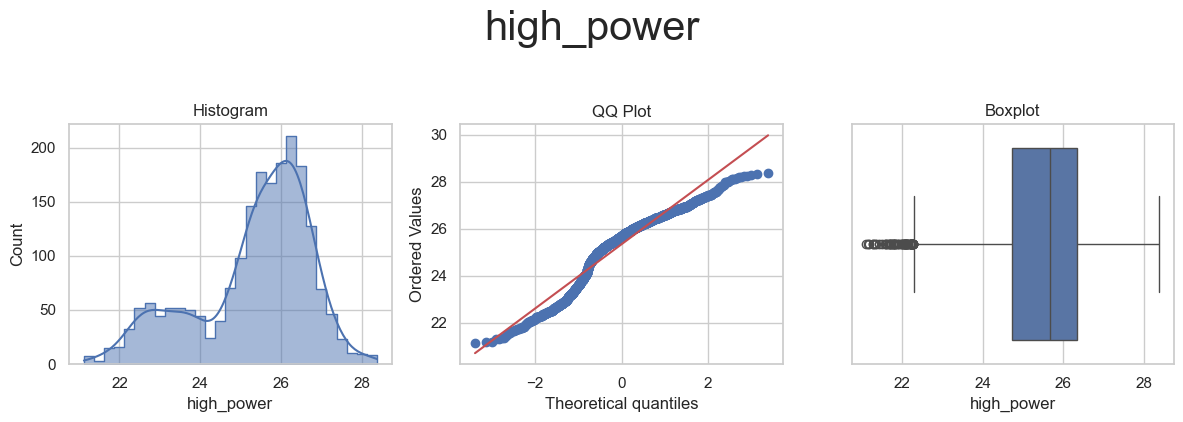

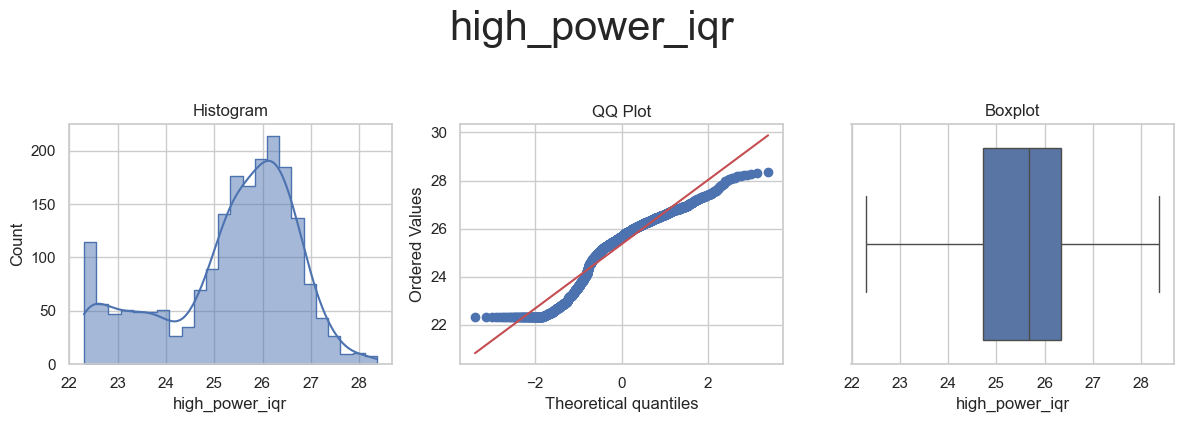



* Variable Analyzed: high_box_cox
* Applied transformation: ['high_box_cox_iqr'] 



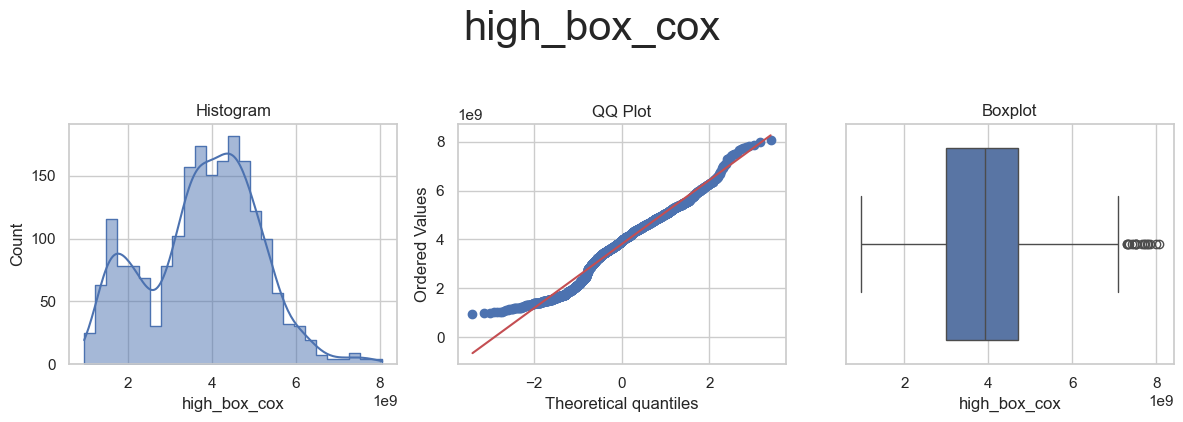

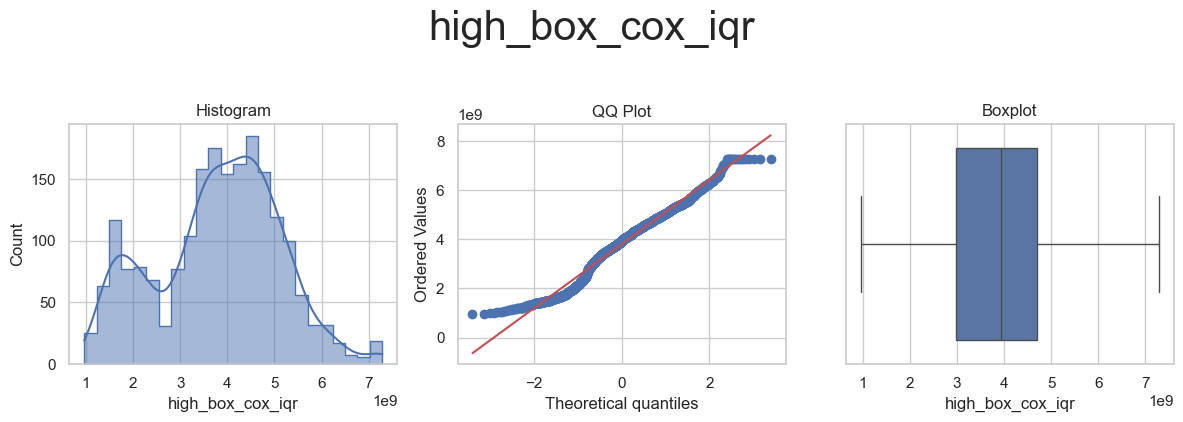



* Variable Analyzed: high_yeo_johnson
* Applied transformation: ['high_yeo_johnson_iqr'] 



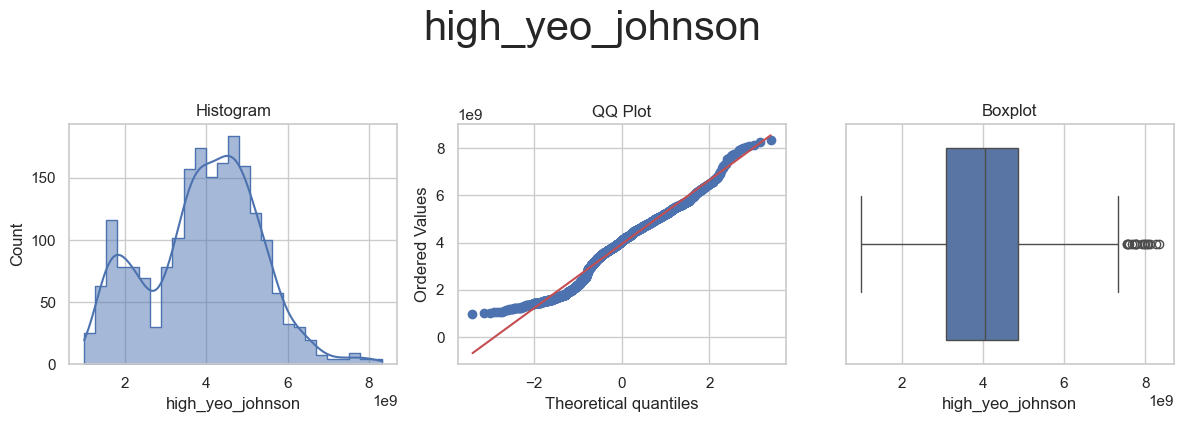

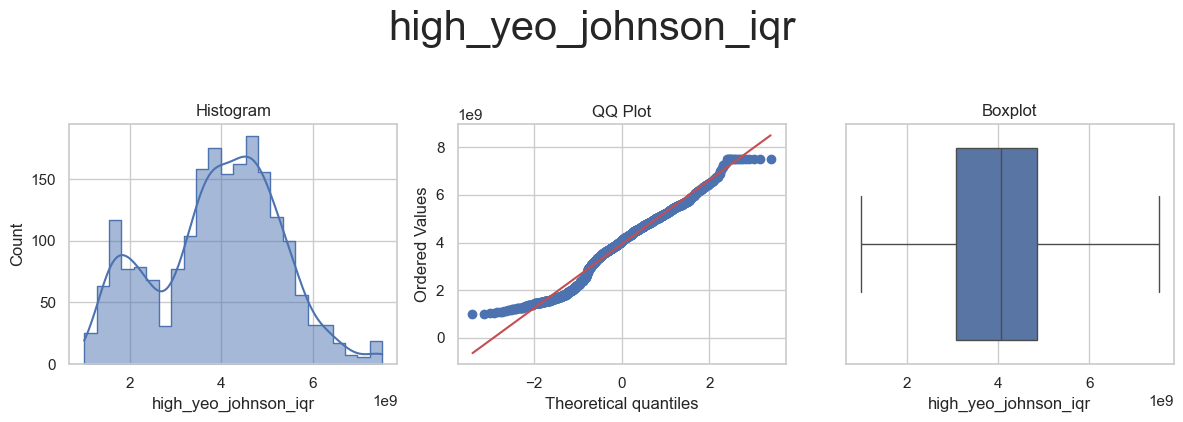



* Variable Analyzed: low
* Applied transformation: ['low_iqr'] 



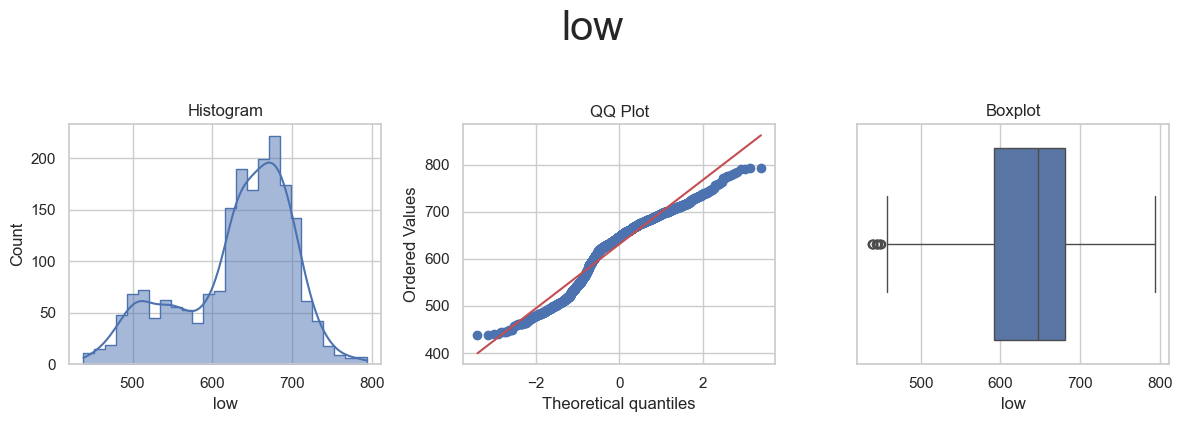

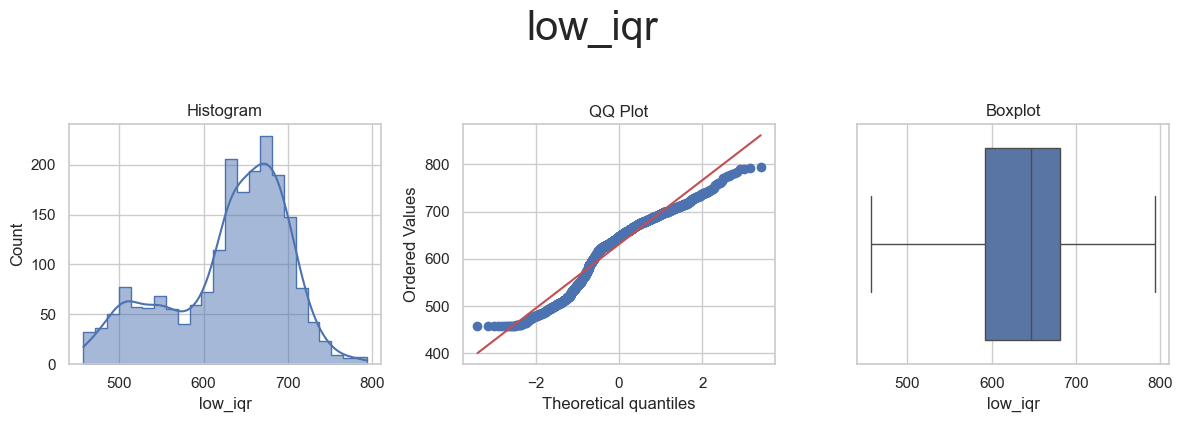



* Variable Analyzed: low_log_e
* Applied transformation: ['low_log_e_iqr'] 



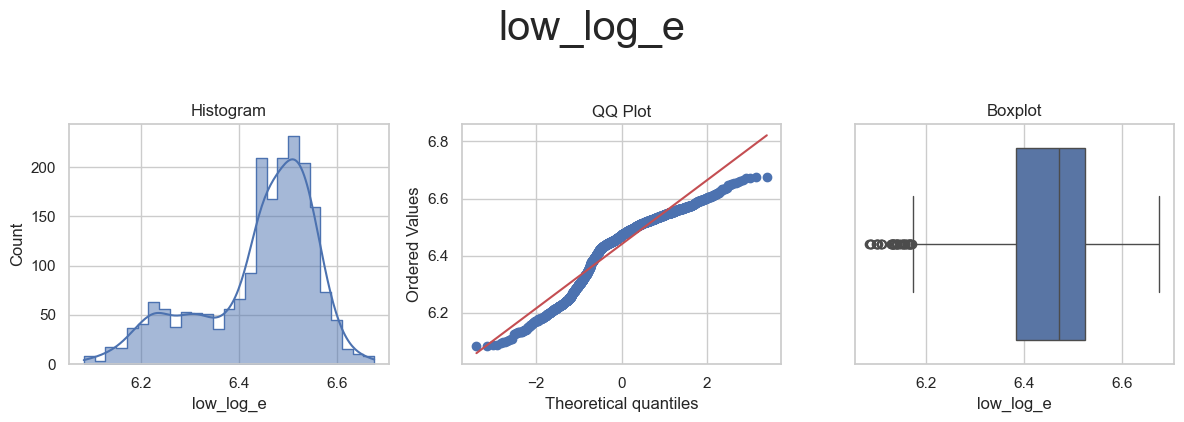

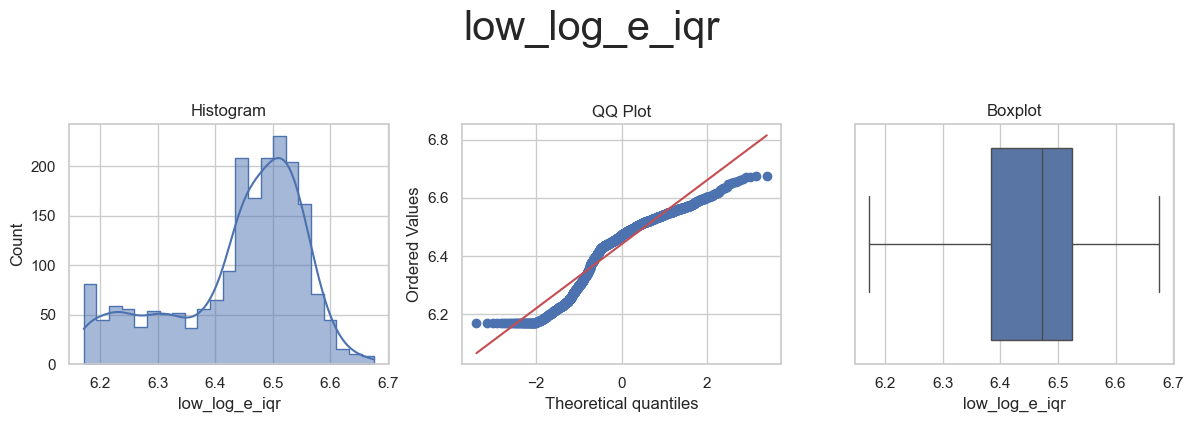



* Variable Analyzed: low_log_10
* Applied transformation: ['low_log_10_iqr'] 



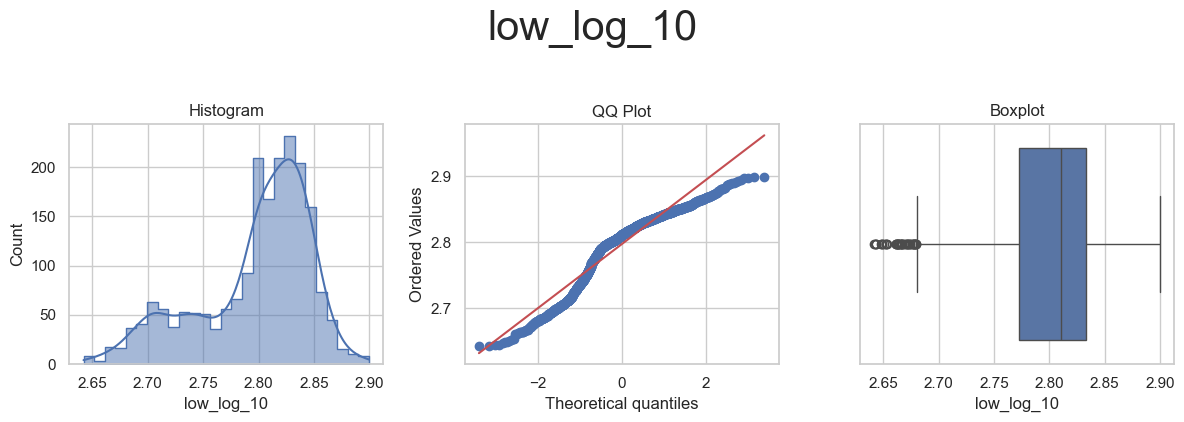

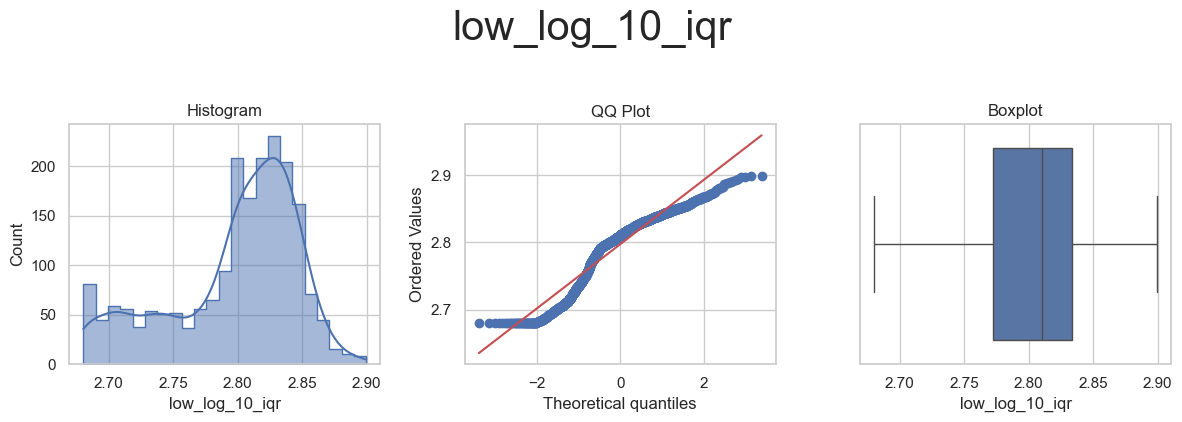



* Variable Analyzed: low_reciprocal
* Applied transformation: ['low_reciprocal_iqr'] 



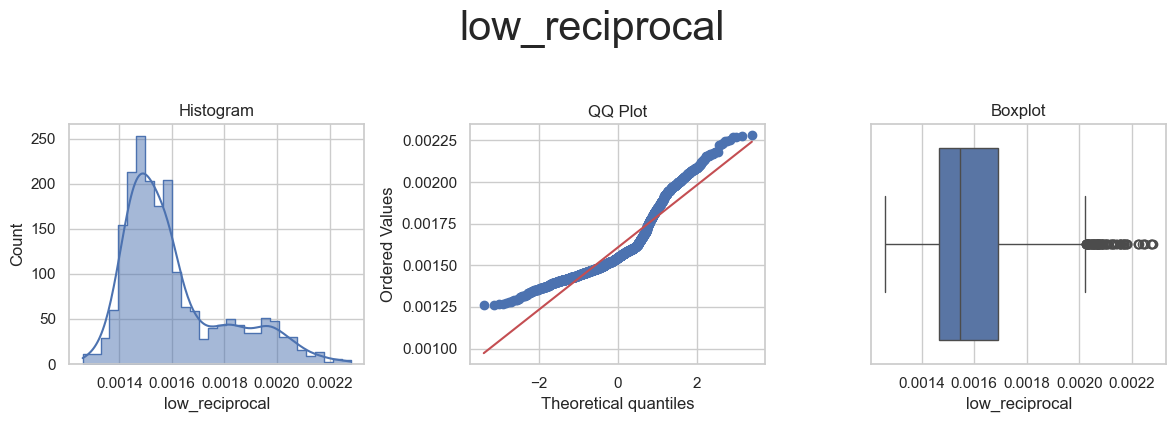

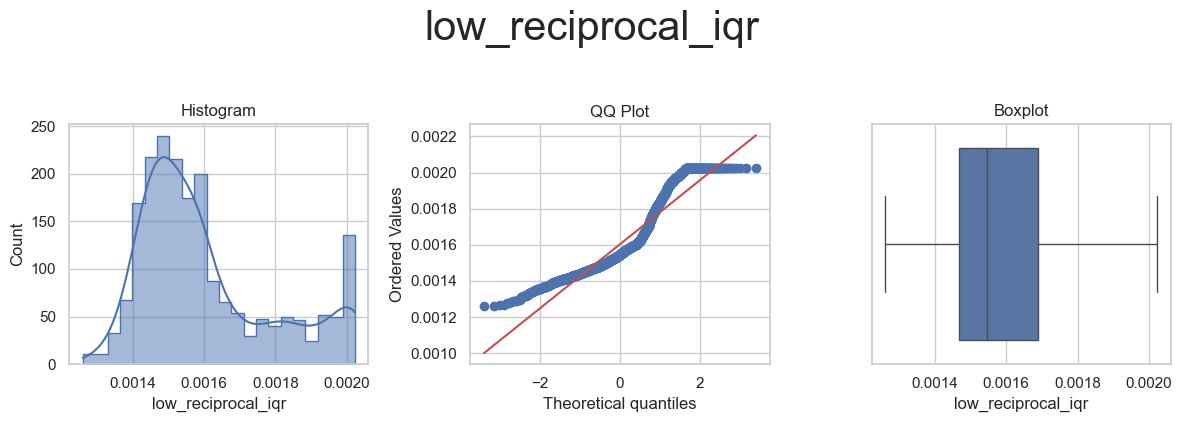



* Variable Analyzed: low_power
* Applied transformation: ['low_power_iqr'] 



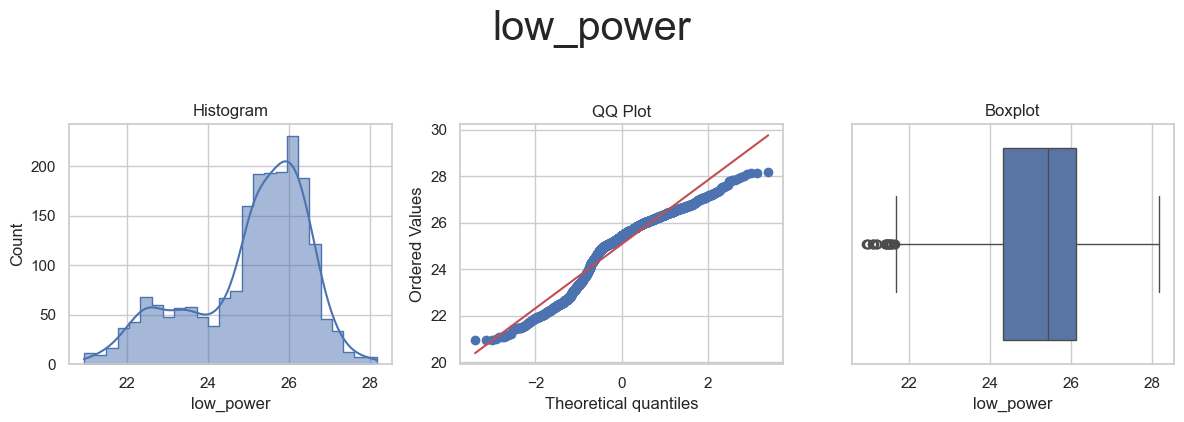

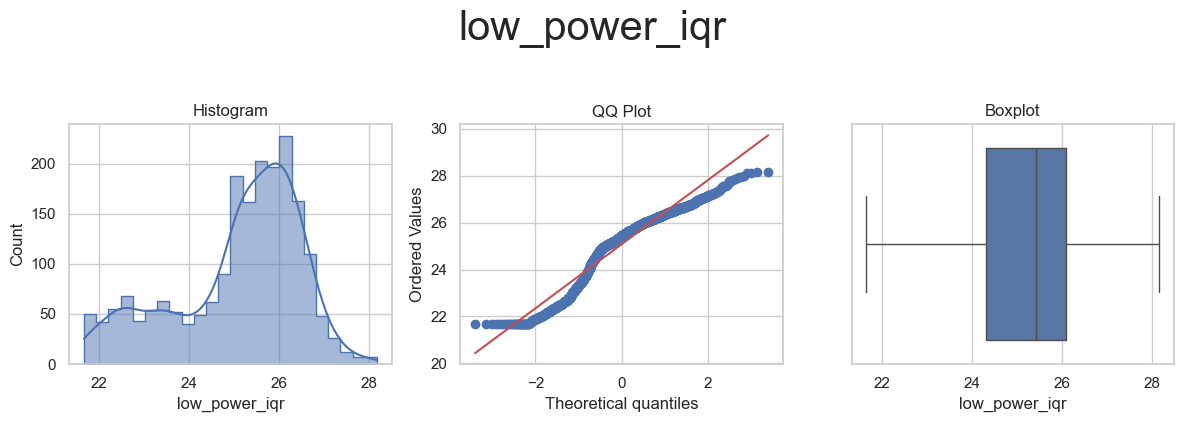



* Variable Analyzed: low_box_cox
* Applied transformation: ['low_box_cox_iqr'] 



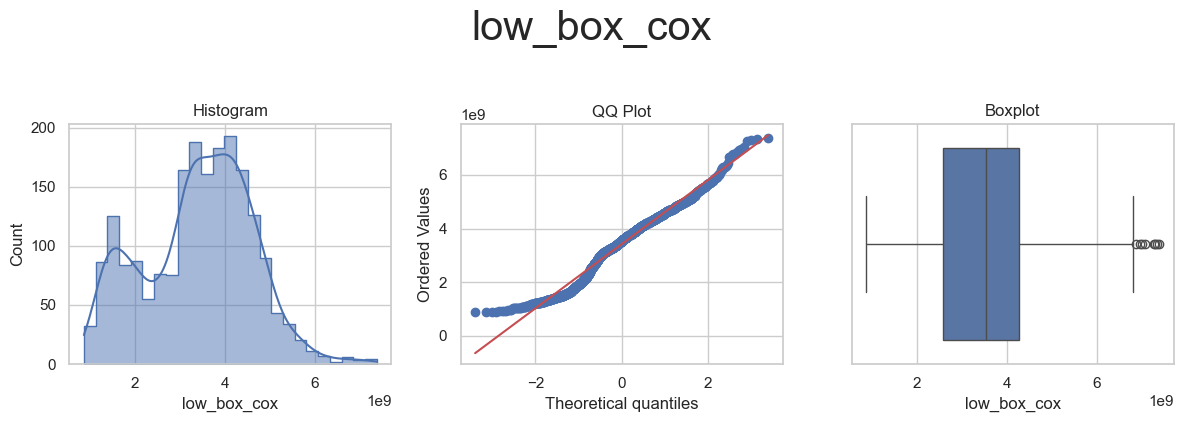

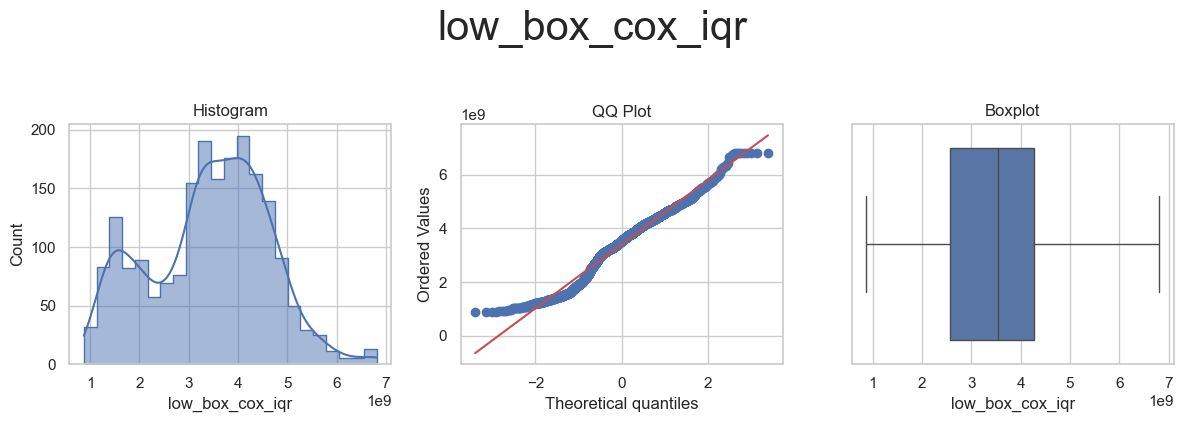



* Variable Analyzed: low_yeo_johnson
* Applied transformation: ['low_yeo_johnson_iqr'] 



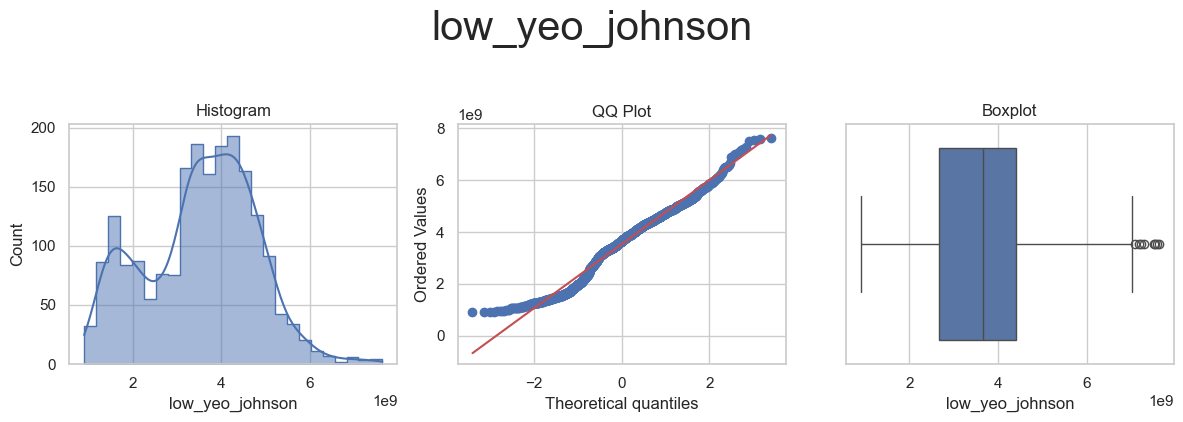

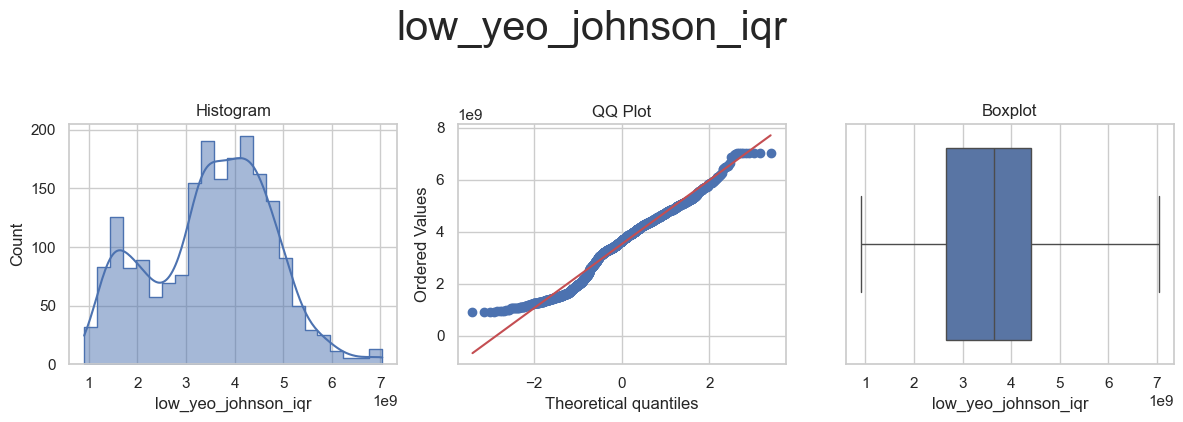



* Variable Analyzed: close
* Applied transformation: ['close_iqr'] 



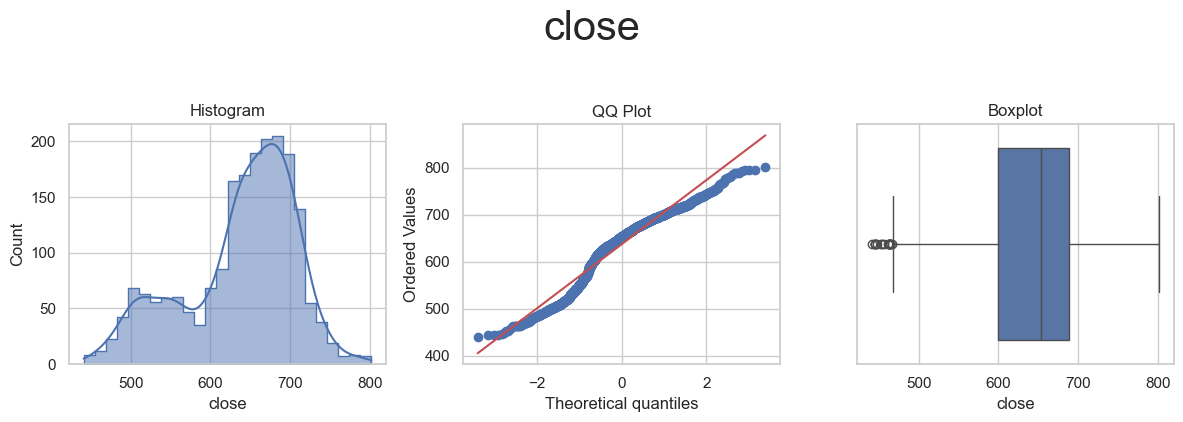

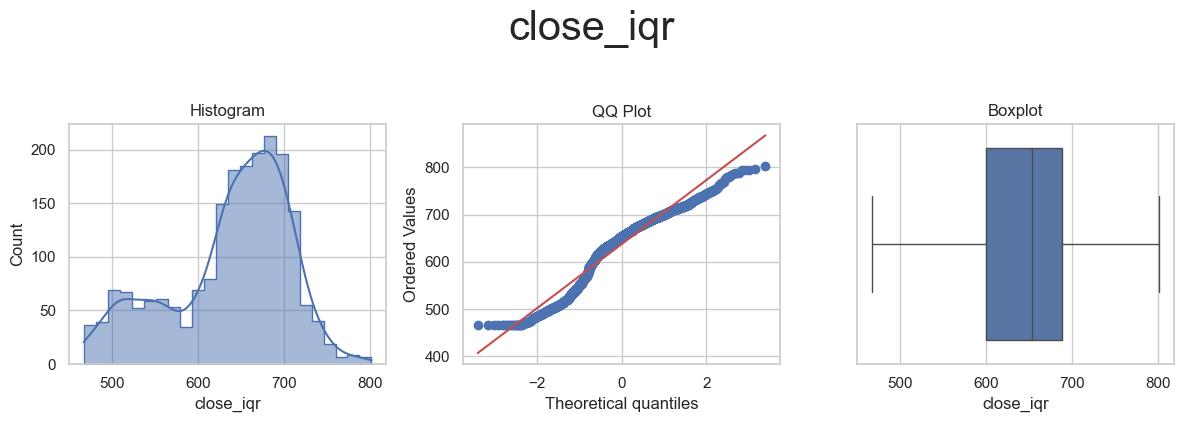



* Variable Analyzed: close_log_e
* Applied transformation: ['close_log_e_iqr'] 



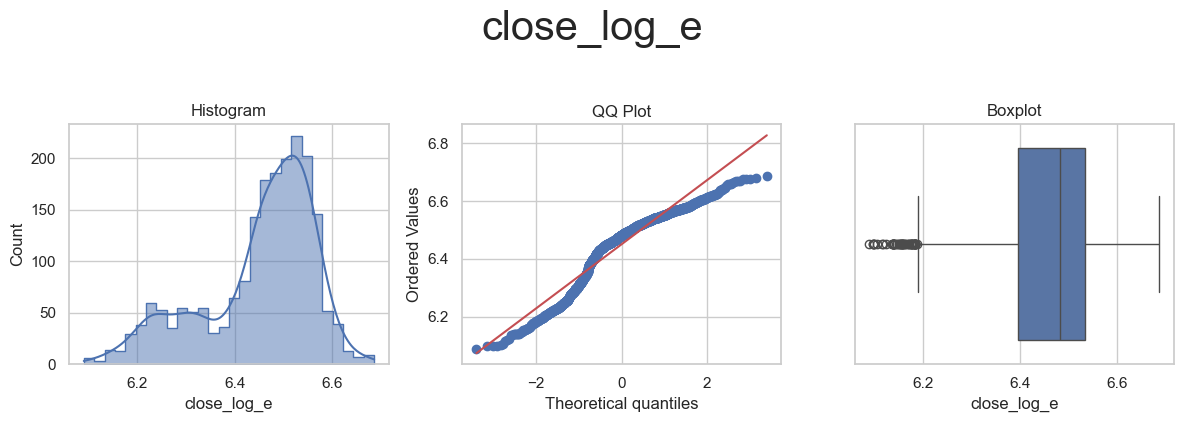

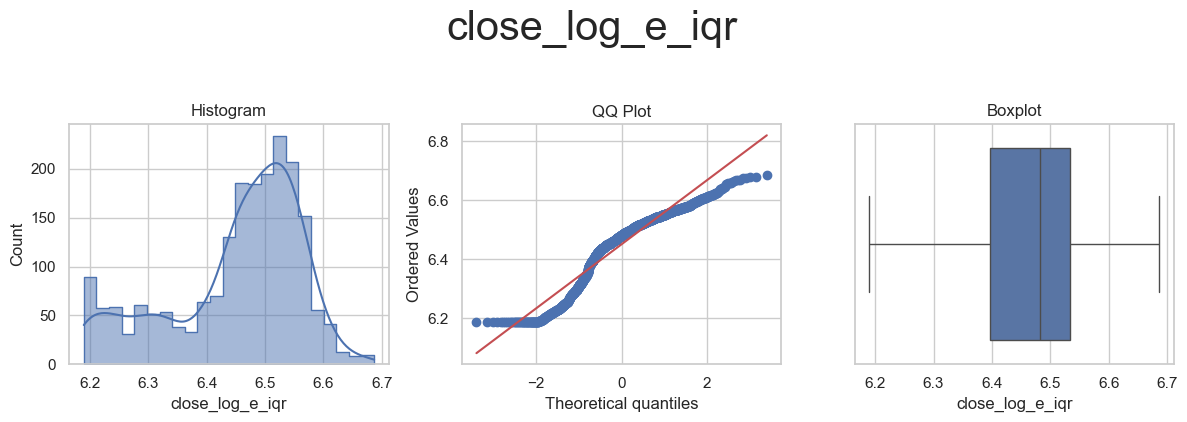



* Variable Analyzed: close_log_10
* Applied transformation: ['close_log_10_iqr'] 



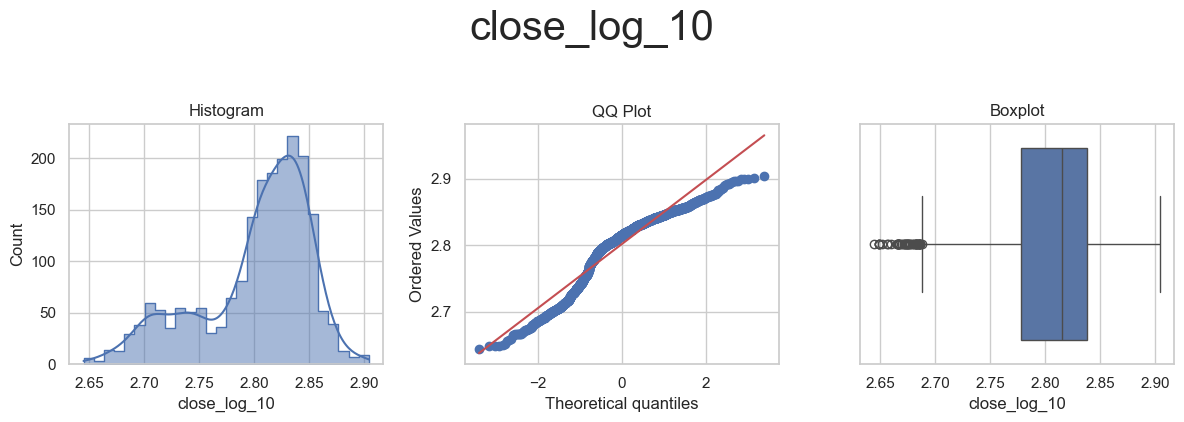

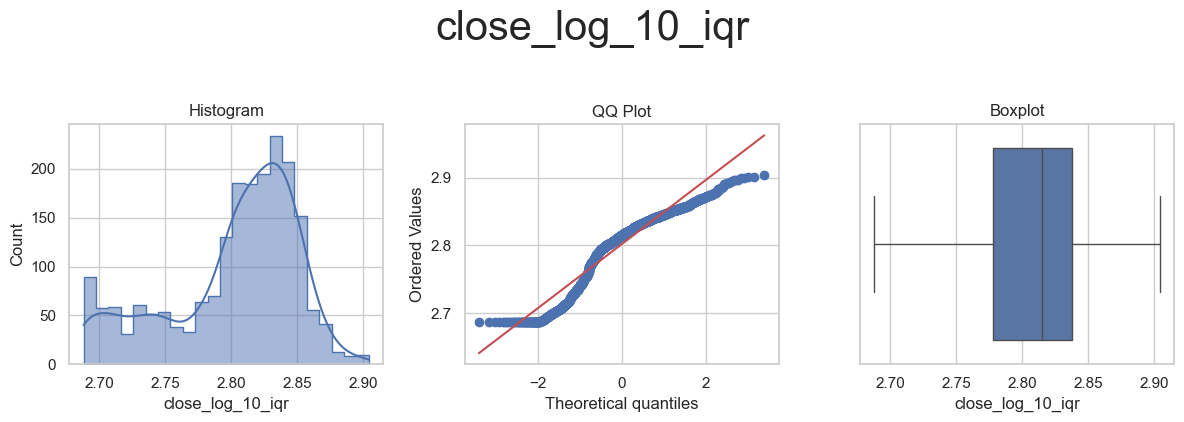



* Variable Analyzed: close_reciprocal
* Applied transformation: ['close_reciprocal_iqr'] 



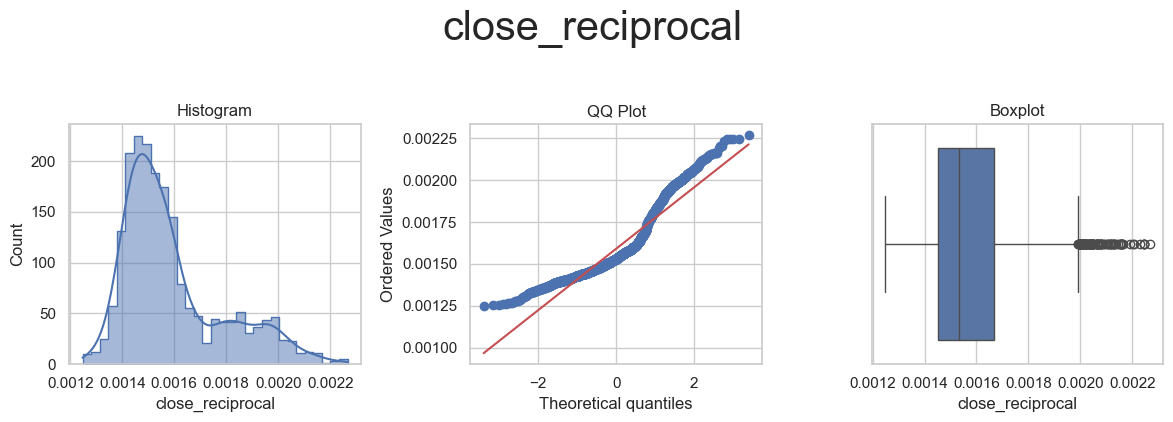

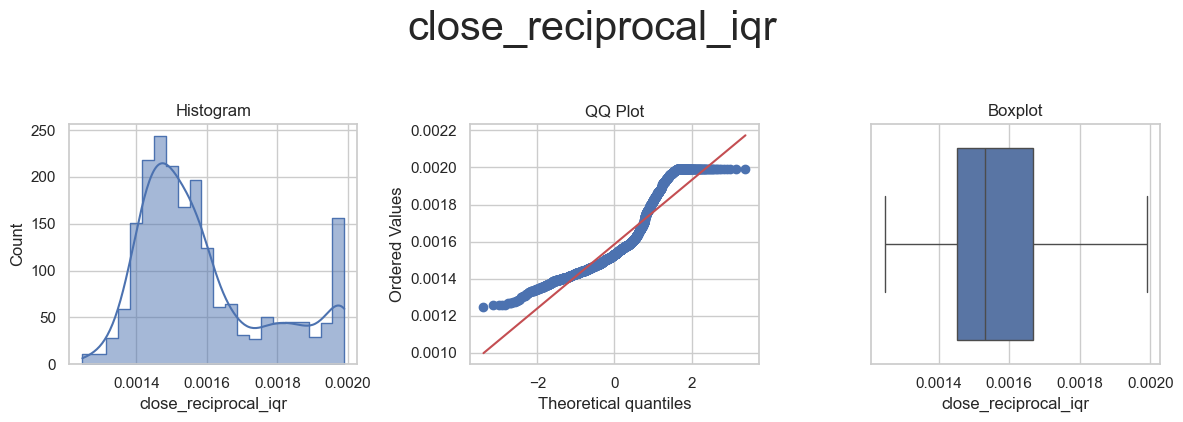



* Variable Analyzed: close_power
* Applied transformation: ['close_power_iqr'] 



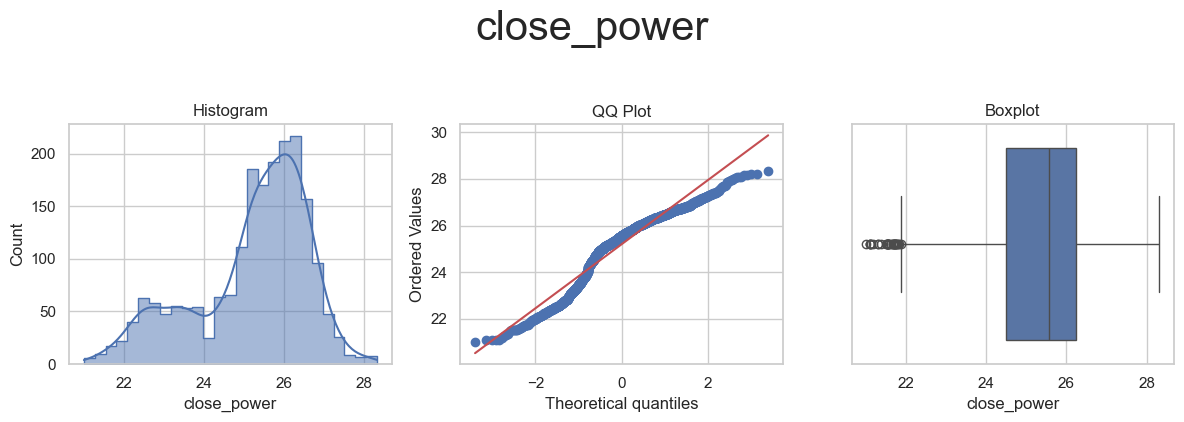

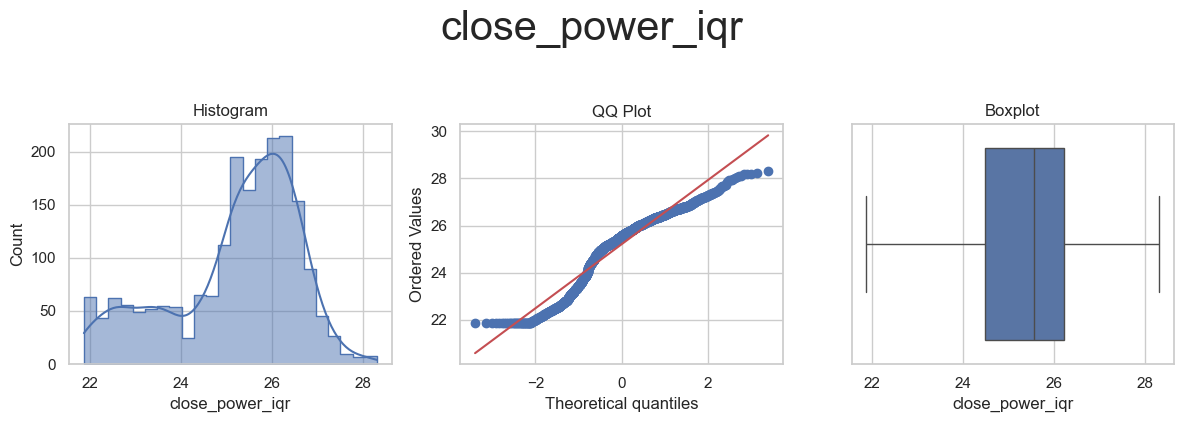



* Variable Analyzed: close_box_cox
* Applied transformation: ['close_box_cox_iqr'] 



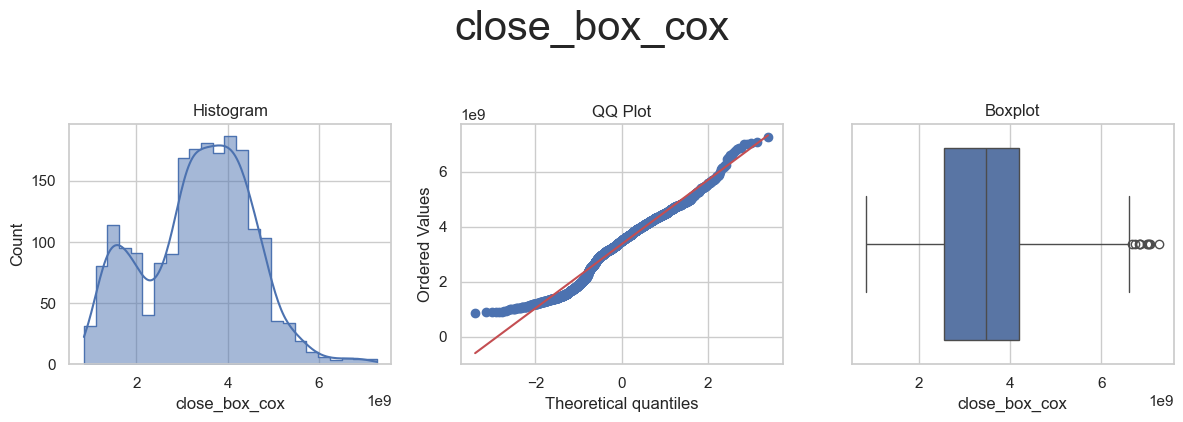

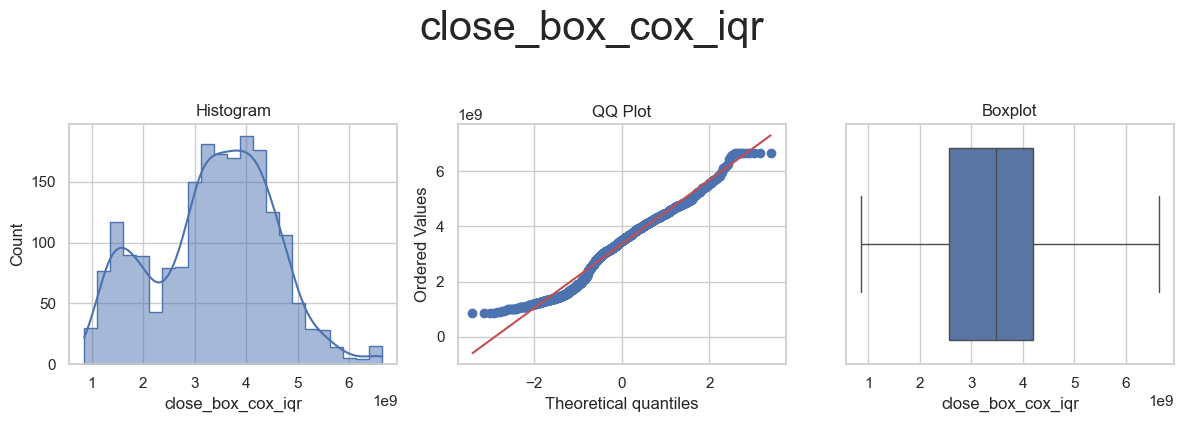



* Variable Analyzed: close_yeo_johnson
* Applied transformation: ['close_yeo_johnson_iqr'] 



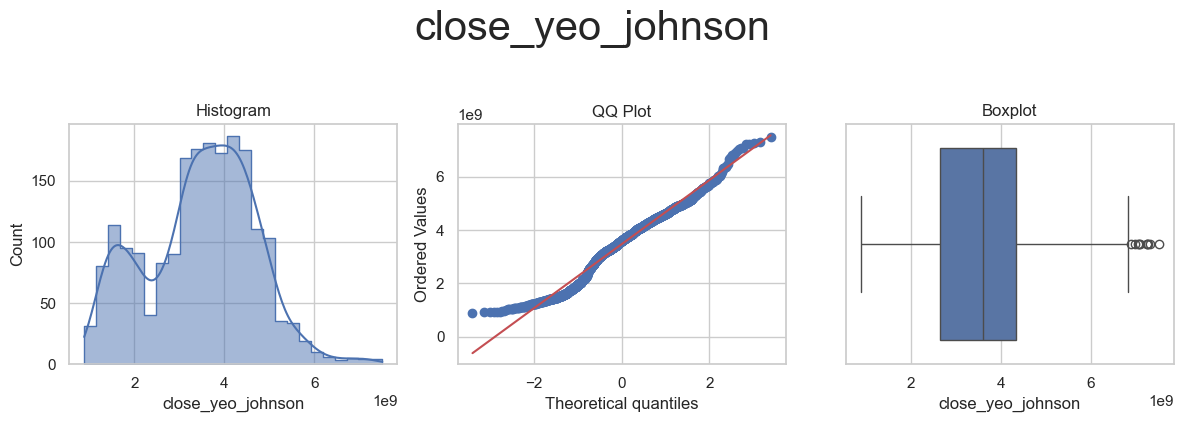

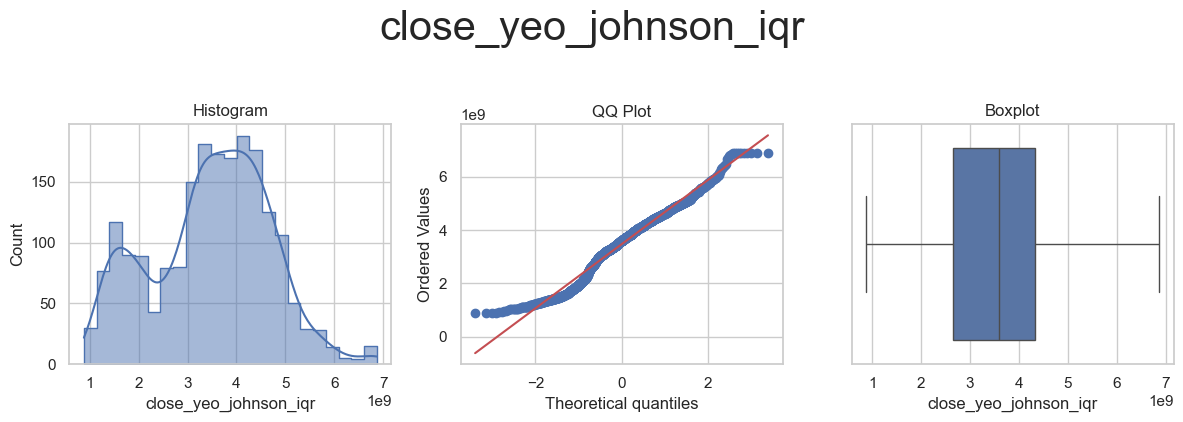



* Variable Analyzed: volume
* Applied transformation: ['volume_iqr'] 



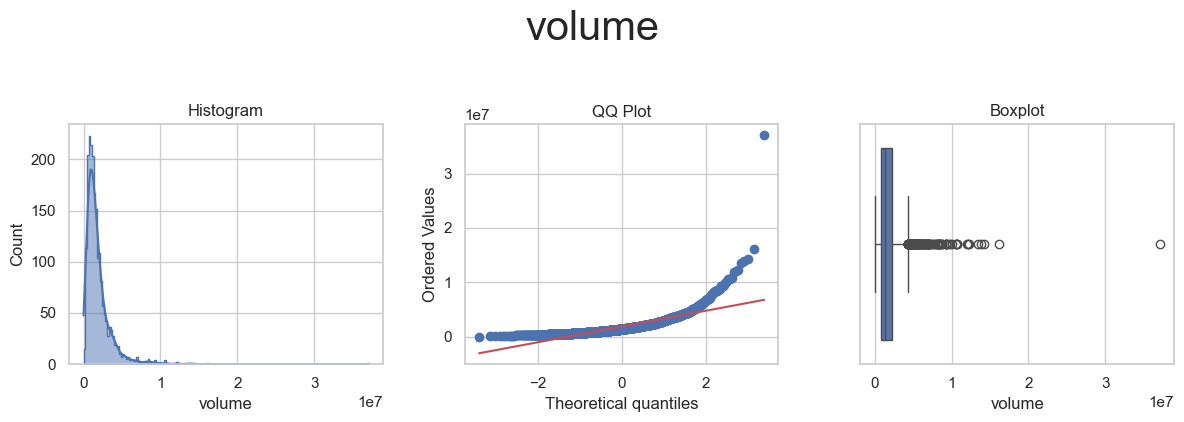

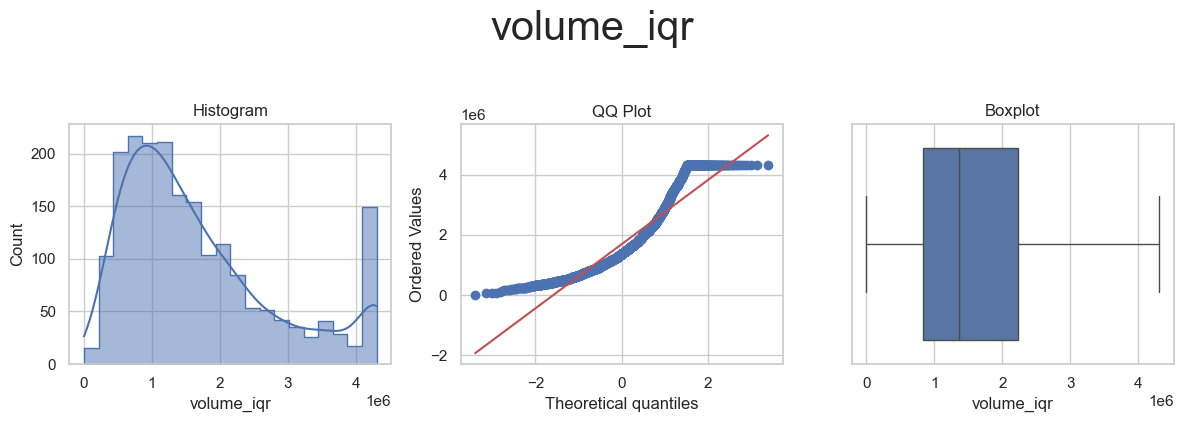



* Variable Analyzed: volume_power
* Applied transformation: ['volume_power_iqr'] 



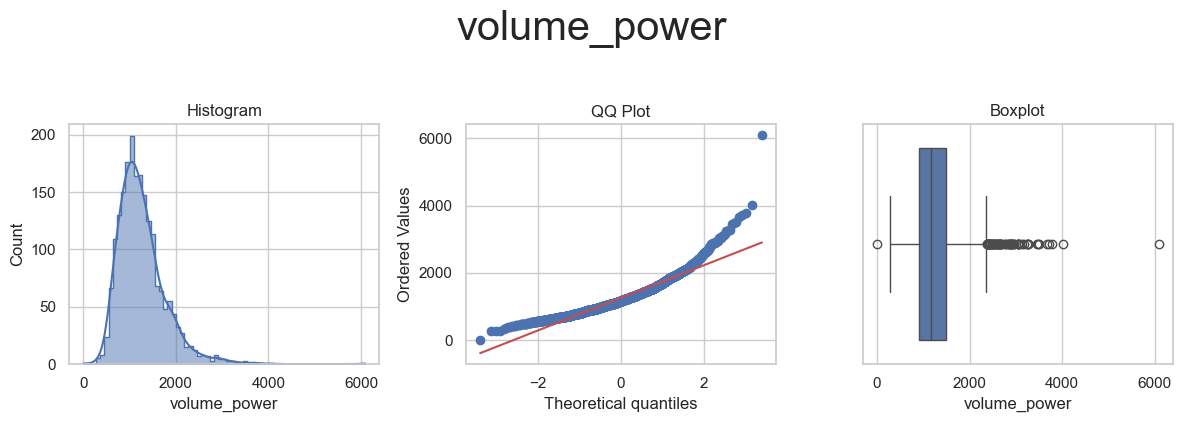

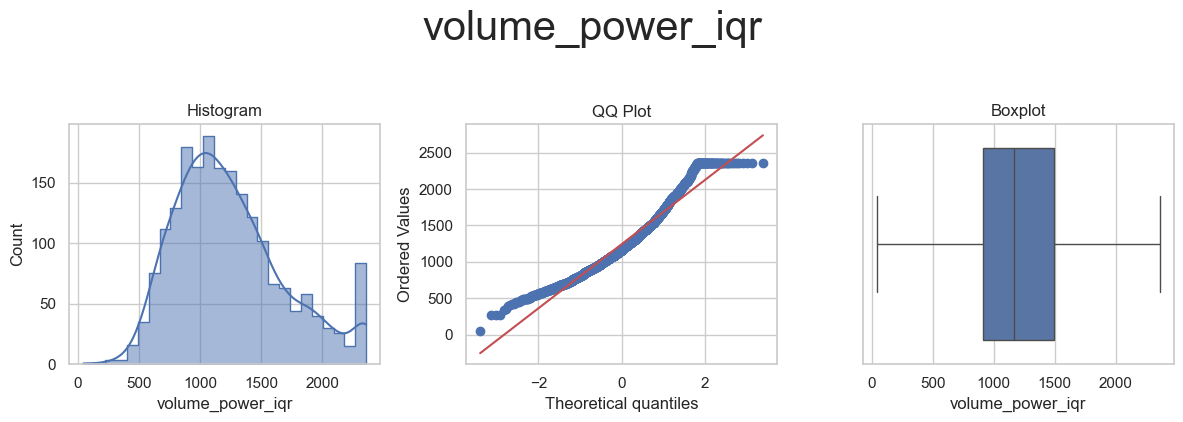



* Variable Analyzed: volume_yeo_johnson
* Applied transformation: ['volume_yeo_johnson_iqr'] 



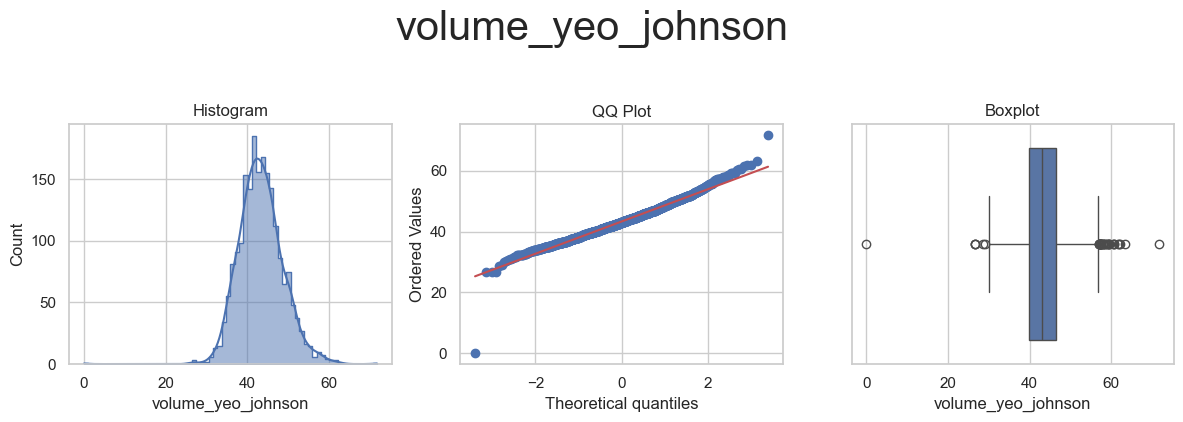

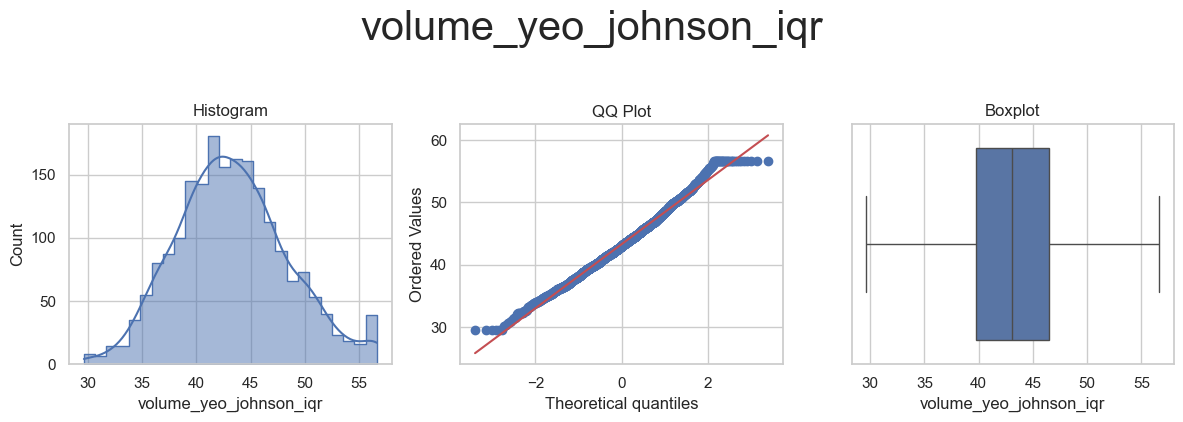

In [17]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

In [18]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Outliers Capped - Winsorizer transformation done!")

* Outliers Capped - Winsorizer transformation done!


In [19]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = vt.YeoJohnsonTransformer(variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Numerical - YeoJohnsonTransformer transformation done!")

* Numerical - YeoJohnsonTransformer transformation done!


In [20]:
print(TrainSet.shape)
TrainSet

(2019, 18)


date          open          high           low         close  \
0        0  2.428168e+09  2.304085e+09  2.927072e+09  2.718059e+09   
1        1  2.443859e+09  2.344566e+09  2.978470e+09  2.807224e+09   
2        2  3.099626e+09  2.966912e+09  3.782887e+09  3.564940e+09   
3        3  1.909027e+09  1.801103e+09  2.282191e+09  2.123356e+09   
4        4  3.164729e+09  2.979290e+09  3.692249e+09  3.393930e+09   
...    ...           ...           ...           ...           ...   
2014  2014  2.427080e+09  2.372555e+09  2.975126e+09  2.849503e+09   
2015  2015  2.899013e+09  2.735653e+09  3.500732e+09  3.279766e+09   
2016  2016  3.683917e+09  3.487900e+09  4.505348e+09  4.207584e+09   
2017  2017  3.484997e+09  3.271458e+09  4.180993e+09  3.898972e+09   
2018  2018  2.933311e+09  2.800143e+09  3.455131e+09  3.300957e+09   

          volume    pre_open    pre_high     pre_low   pre_close    pre_vol  \
0      93.204207  628.525235  638.822628  628.525235  630.813599   507115.0   
1      94.162747  630.050708  630.050708  620.516002  623.948486   355145.0   
2     103.888430  681.835163  684.975197  676.210054  678.695251   497156.0   
3     127.909835  588.030211  600.018595  586.831421  586.831421  3300008.0   
4     103.762531  677.342782  680.119231  672.766116  678.105530  1193683.0   
...          ...         ...         ...         ...         ...        ...   
2014  119.240944  634.816730  637.711754  629.226234  631.322693   920930.0   
2015  107.013615  652.367974  665.755029  652.367974  661.559082  1134797.0   
2016  132.148149  698.881124  710.095478  698.881124  706.955444   874316.0   
2017  121.327186  707.629252  709.424137  696.860004  700.001038  1252310.0   
2018  172.990430  674.146777  674.945990  655.564806  659.960510  2773671.0   

      pre_open_2  pre_high_2   pre_low_2  pre_close_2  pre_vol_2     average  \
0     630.050676  632.720413  623.567081   628.906555   376258.0  628.715803   
1     623.185739  630.050708  622.041557   623.948486   546269.0  632.148386   
2     667.929442  681.386704  667.929442   680.938171   856953.0  676.003796   
3     582.036066  613.605516  579.438607   591.227173  3730232.0  587.031249   
4     668.952122  669.562381  663.612649   669.333496   882149.0  673.338220   
...          ...         ...         ...          ...        ...         ...   
2014  637.911404  638.510357  629.126408   632.919922  2098583.0  632.870058   
2015  660.160379  663.956689  651.968304   652.767578  1944842.0  661.858771   
2016  695.741082  701.572556  694.395302   701.124023   787763.0  708.974172   
2017  688.334222  710.770250  688.334222   707.180420  1734565.0  695.962408   
2018  685.935414  688.932510  674.146847   678.742432  1677855.0  663.557139   

      target  
0          0  
1          0  
2          1  
3          0  
4          0  
...      ...  
2014       1  
2015       0  
2016       1  
2017       1  
2018       1  

[2019 rows x 18 columns]

---

# Section 2

Section 2 content

In [22]:
df_engineering = TrainSet.copy()
df_engineering.head(3)

date          open          high           low         close      volume  \
0     0  2.428168e+09  2.304085e+09  2.927072e+09  2.718059e+09   93.204207   
1     1  2.443859e+09  2.344566e+09  2.978470e+09  2.807224e+09   94.162747   
2     2  3.099626e+09  2.966912e+09  3.782887e+09  3.564940e+09  103.888430   

     pre_open    pre_high     pre_low   pre_close   pre_vol  pre_open_2  \
0  628.525235  638.822628  628.525235  630.813599  507115.0  630.050676   
1  630.050708  630.050708  620.516002  623.948486  355145.0  623.185739   
2  681.835163  684.975197  676.210054  678.695251  497156.0  667.929442   

   pre_high_2   pre_low_2  pre_close_2  pre_vol_2     average  target  
0  632.720413  623.567081   628.906555   376258.0  628.715803       0  
1  630.050708  622.041557   623.948486   546269.0  632.148386       0  
2  681.386704  667.929442   680.938171   856953.0  676.003796       1

In [23]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'average',
  'close',
  'high',
  'low',
  'open',
  'pre_close',
  'pre_close_2',
  'pre_high',
  'pre_high_2',
  'pre_low',
  'pre_low_2',
  'pre_open',
  'pre_open_2'},
 {'pre_vol', 'pre_vol_2', 'volume'}]

In [24]:
corr_sel.features_to_drop_

['close',
 'open',
 'high',
 'pre_high',
 'pre_open',
 'pre_close',
 'pre_low',
 'pre_close_2',
 'pre_high_2',
 'pre_open_2',
 'average',
 'pre_low_2',
 'pre_vol_2',
 'volume']

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [21]:
try:
  # create here your folder
  os.makedirs(name='')
except Exception as e:
  print(e)


[WinError 3] The system cannot find the path specified: ''
